# Trying to find the unit circle

A small example to demonstrate EDO's capacity to optimise a simple function:

$$
f(X) = \max_{j, k} \left\{%
    \frac{\text{Var}\left(X_{j}\right)}{\max_{i} \left|X_{i, k} - 1\right|}
\right\}
$$

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

import edo
from edo.distributions import Uniform

plt.style.use("seaborn-colorblind")
%matplotlib inline

In [2]:
class RadiusUniform(Uniform):
    """ A Uniform child for capturing the radius of a point in the unit
    circle. """

    name = "RadiusUniform"
    param_limits = {"bounds": [0, 1.5]}


class AngleUniform(Uniform):
    """ A Uniform child for capturing the angle of a point in the unit
    circle. """

    name = "AngleUniform"
    param_limits = {"bounds": [-2 * np.pi, 2 * np.pi]}


def split_individual(individual):
    """ Separate the columns of an individual's dataframe. """

    df, metadata = individual
    names = [m.name for m in metadata]
    radii = df[names.index("RadiusUniform")]
    angles = df[names.index("AngleUniform")]

    return radii, angles
    
    
def fitness(individual):
    """ Determine the similarity of the dataframe to the unit circle. """

    radii, angles = split_individual(individual)
    return angles.var() / (radii - 1).abs().max()

In [3]:
size = 100
row_limits = [50, 100]
col_limits = [(1, 1), (1, 1)]
max_iter = 30
best_prop = 0.1
num_seeds = 5

In [4]:
%%time

pop_histories, fit_histories = [], []
for seed in range(num_seeds):

    families = [edo.Family(RadiusUniform), edo.Family(AngleUniform)]

    opt = edo.DataOptimiser(
        fitness,
        size,
        row_limits,
        col_limits,
        families,
        max_iter=max_iter,
        best_prop=best_prop,
        maximise=True,
    )

    pops, fits = opt.run(random_state=seed)
    
    fits["seed"] = seed
    pop_histories.append(pops)
    fit_histories.append(fits)

CPU times: user 38.3 s, sys: 332 ms, total: 38.6 s
Wall time: 38.7 s


In [5]:
fit_history = pd.concat(fit_histories)

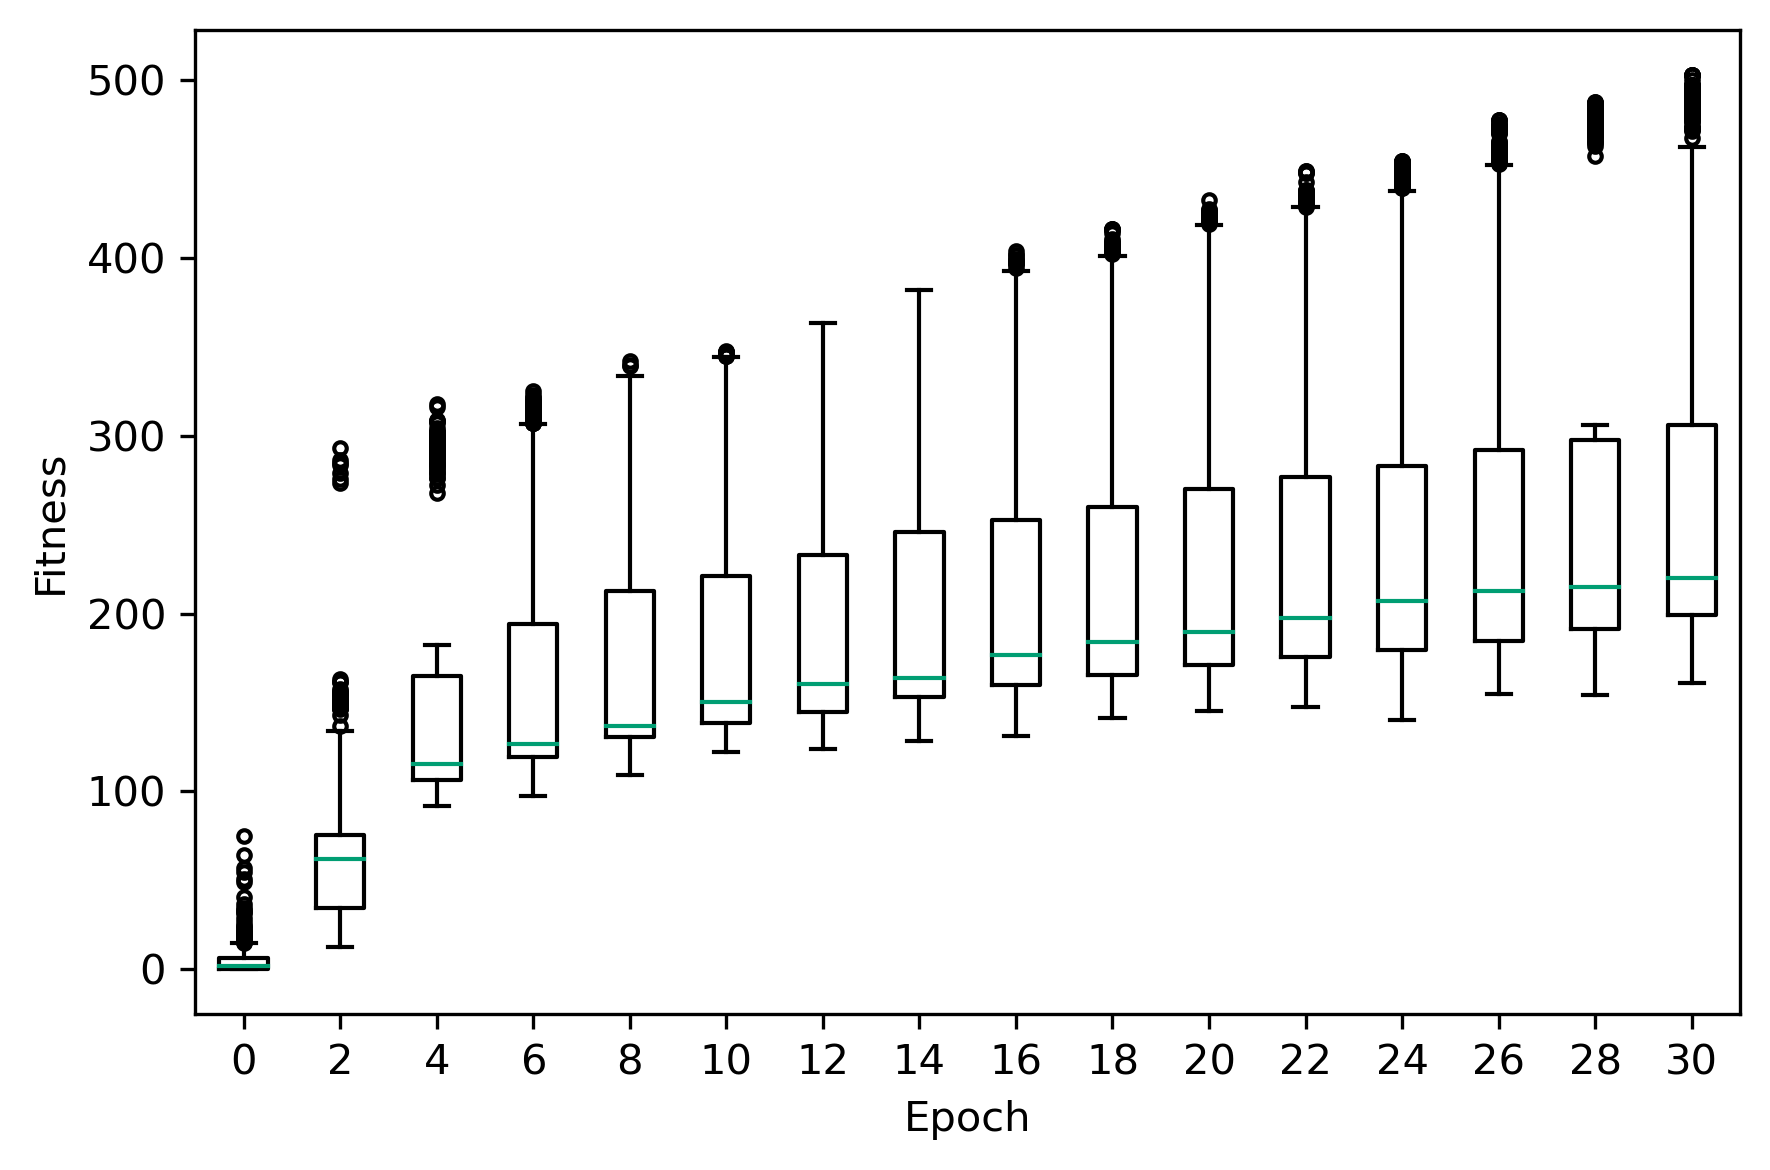

In [6]:
_, ax = plt.subplots(dpi=300)

epochs = range(0, max_iter + 1, 2)
fit = fit_history[fit_history["generation"].isin(epochs)]

xticklabels = []
for pos, (gen, data) in enumerate(fit.groupby("generation")):
    ax.boxplot(data["fitness"], positions=[pos], widths=0.5, sym=".")
    xticklabels.append(gen)

ax.set_xticklabels(xticklabels)
ax.set_xlabel("Epoch")
ax.set_ylabel("Fitness")

plt.tight_layout()
plt.savefig("../img/circle_fitness.pdf", transparent=True)

In [7]:
def get_best_individual(pop_histories, fit_history, epoch=None):

    if isinstance(epoch, int):
        fit_history = fit_history[fit_history["generation"] <= epoch]

    best_idx = fit_history["fitness"].idxmax()
    seed, gen, ind = fit_history[["seed", "generation", "individual"]].iloc[best_idx, :]
    best = pop_histories[seed][gen][ind]

    return best


def convert_polar_to_cartesian(individual):

    radii, angles = split_individual(individual)
    xs, ys = radii * np.cos(angles), radii * np.sin(angles)

    return xs, ys


def scatter_individual(
    individual, color=None, lims=(-1.5, 1.5), ax=None, filename=None
):

    if ax is None:
        _, ax = plt.subplots(dpi=300)

    xs, ys = convert_polar_to_cartesian(individual)

    ax.scatter(xs, ys, marker=".", color=color)
    ax.set(xlim=lims, ylim=lims, aspect="equal")

    plt.tight_layout()
    if filename is not None:
        plt.savefig(f"../img/{filename}.pdf", transparent=True)

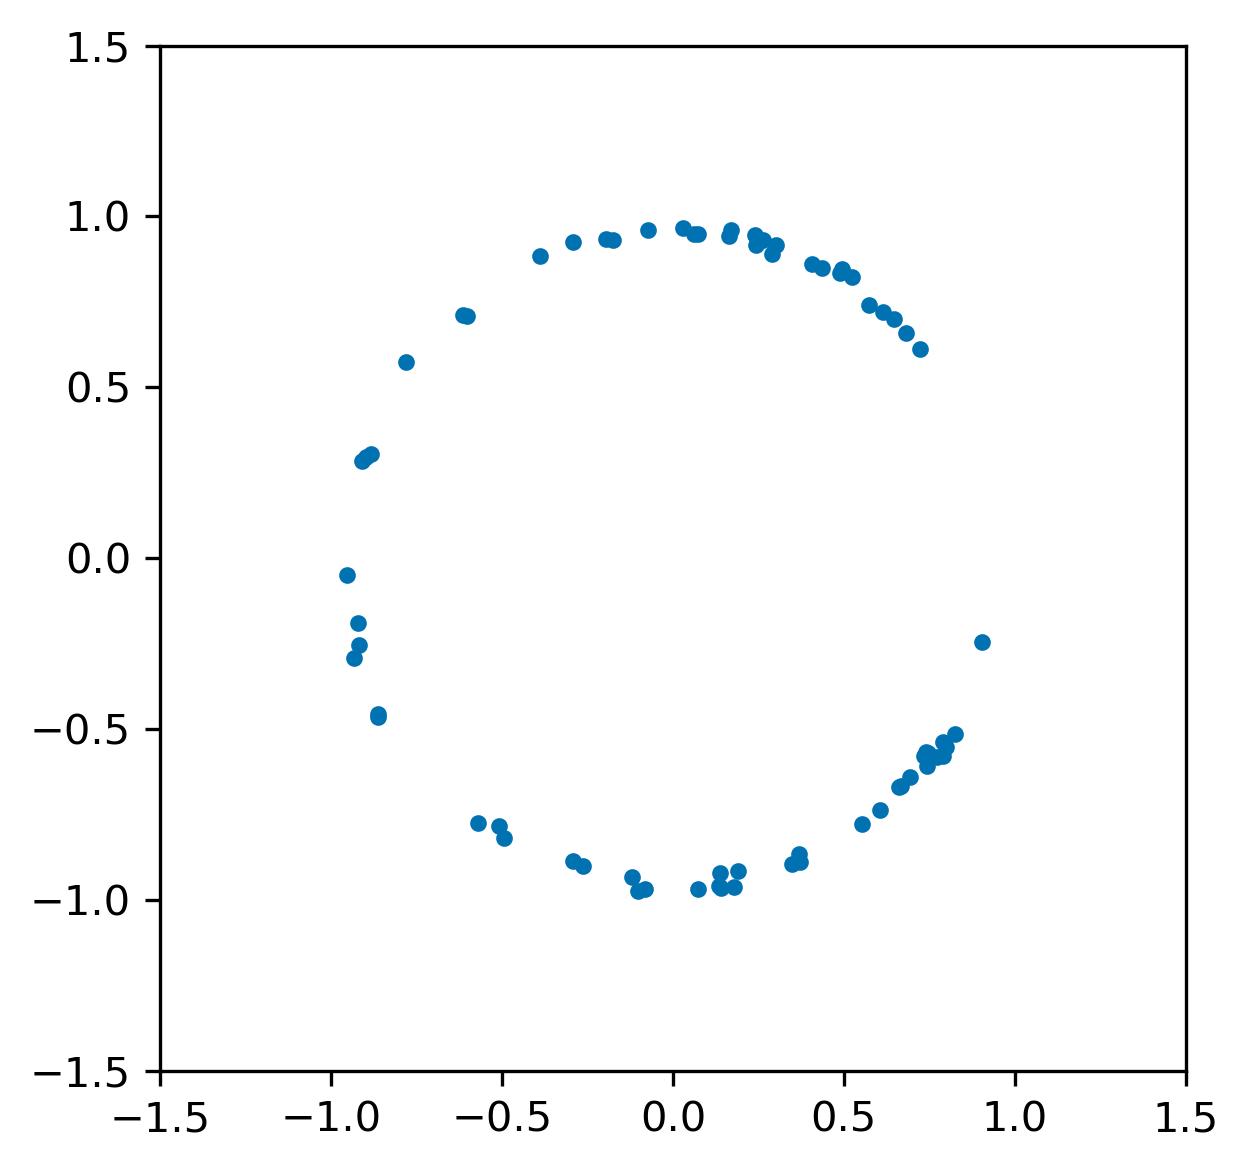

In [8]:
best = get_best_individual(pop_histories, fit_history)
scatter_individual(best)

In [9]:
def concatenate_points(pop_histories, fit_history, quantile, epoch=None):

    if isinstance(epoch, int):
        fit_history = fit_history[fit_history["generation"] <= epoch]
    
    xs_list, ys_list = [], []
    for seed, history in enumerate(pop_histories):
        fit = fit_history[fit_history["seed"] == seed]
        upper_quantile = fit["fitness"].quantile(quantile)
        acceptable = fit[fit["fitness"] > upper_quantile][["generation", "individual"]]
        for _, (gen, ind) in acceptable.iterrows():

            individual = history[gen][ind]
            xs, ys = convert_polar_to_cartesian(individual)

            xs_list.extend(xs)
            ys_list.extend(ys)

    return xs, ys


def get_contour_grid(xs, ys, min_, max_):

    values = np.vstack([xs, ys])
    kernel = gaussian_kde(values)

    xs, ys = np.mgrid[min_:max_:100j, min_:max_:100j]
    positions = np.vstack([xs.ravel(), ys.ravel()])

    zs = np.reshape(kernel(positions).T, xs.shape)

    return xs, ys, zs


def contourplot(
    pop_histories,
    fit_history,
    quantile=1 - best_prop,
    ax=None,
    lims=(-1.5, 1.5),
    scatter=True,
    epoch=None,
    circle=True,
    axes=False,
    filename=None,
):

    if ax is None:
        _, ax = plt.subplots(dpi=600)

    xs, ys = concatenate_points(pop_histories, fit_history, quantile, epoch)
    xs, ys, zs = get_contour_grid(xs, ys, *lims)

    ax.contourf(xs, ys, zs, levels=5, cmap="viridis_r")

    if scatter is True:
        best = get_best_individual(pop_histories, fit_history, epoch)
        scatter_individual(best, color="white", lims=lims, ax=ax)

    if circle is True:
        circle = plt.Circle((0, 0), 1, fill=False, linestyle="--", color="tab:gray")
        ax.add_artist(circle)

    if axes is False:
        ax.axis("off")

    ax.set(xlim=lims, ylim=lims, aspect="equal")

    plt.tight_layout()
    if filename is not None:
        plt.savefig(f"../img/{filename}.pdf", transparent=True)

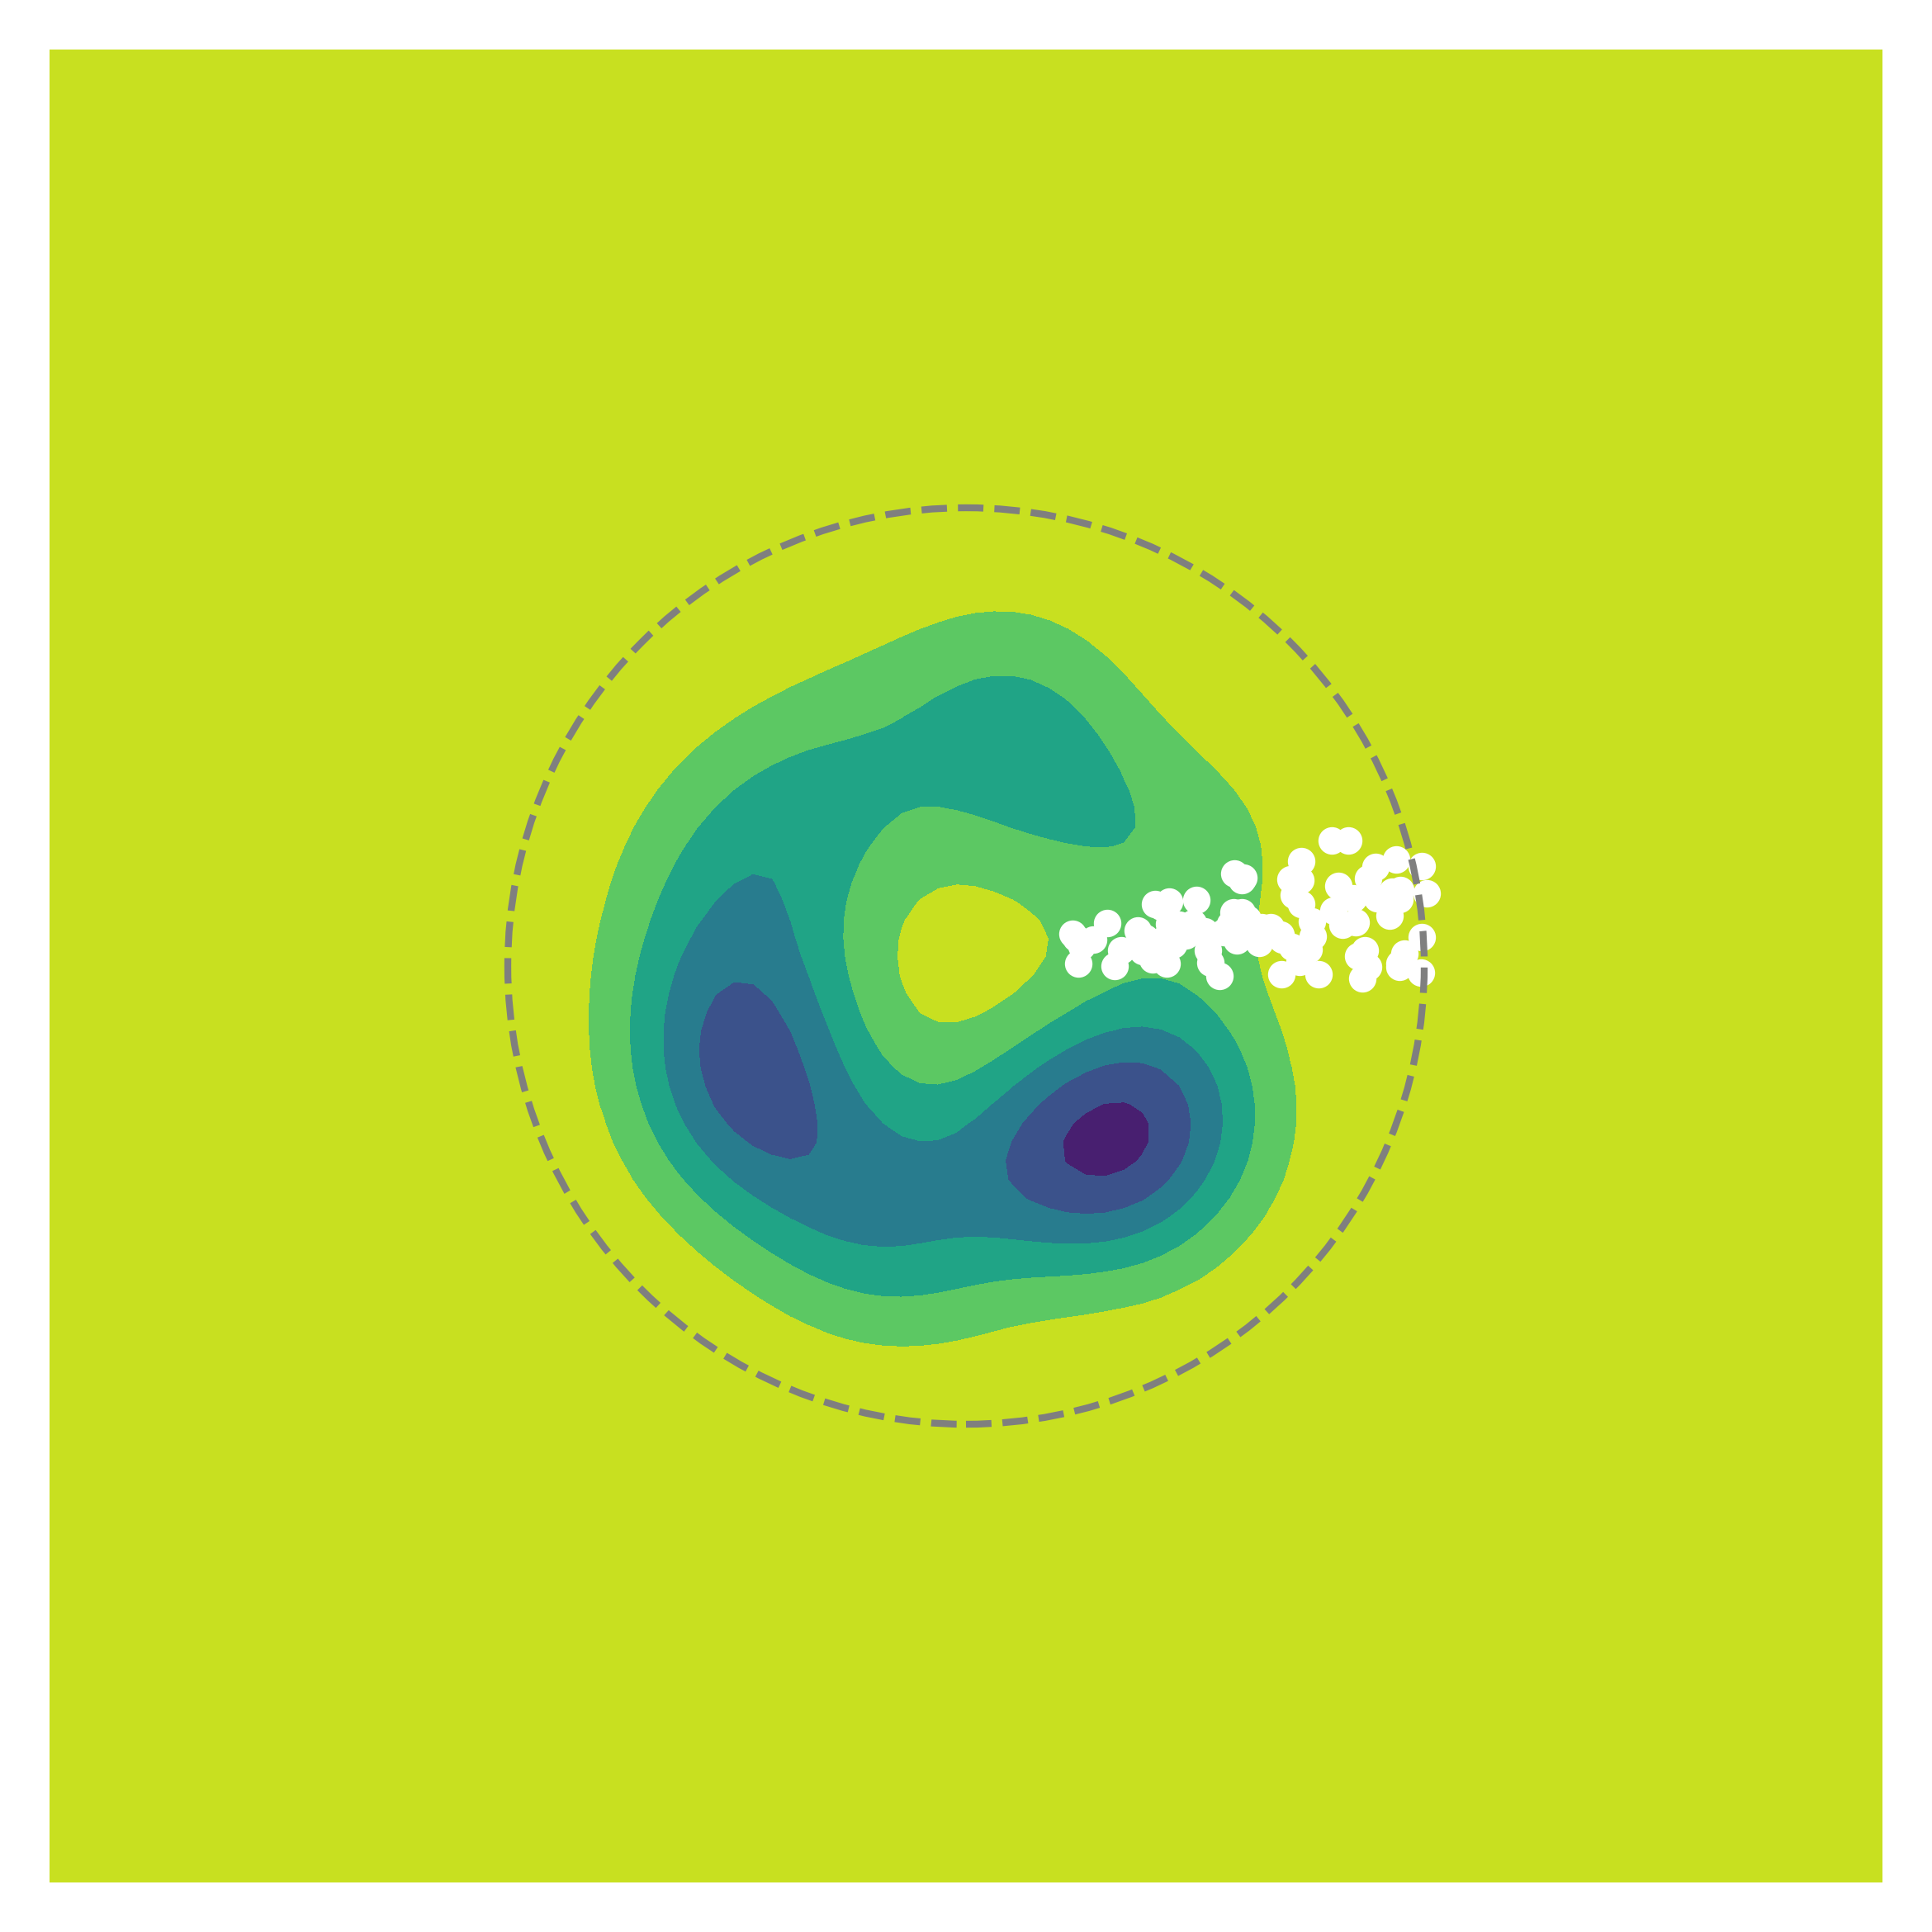

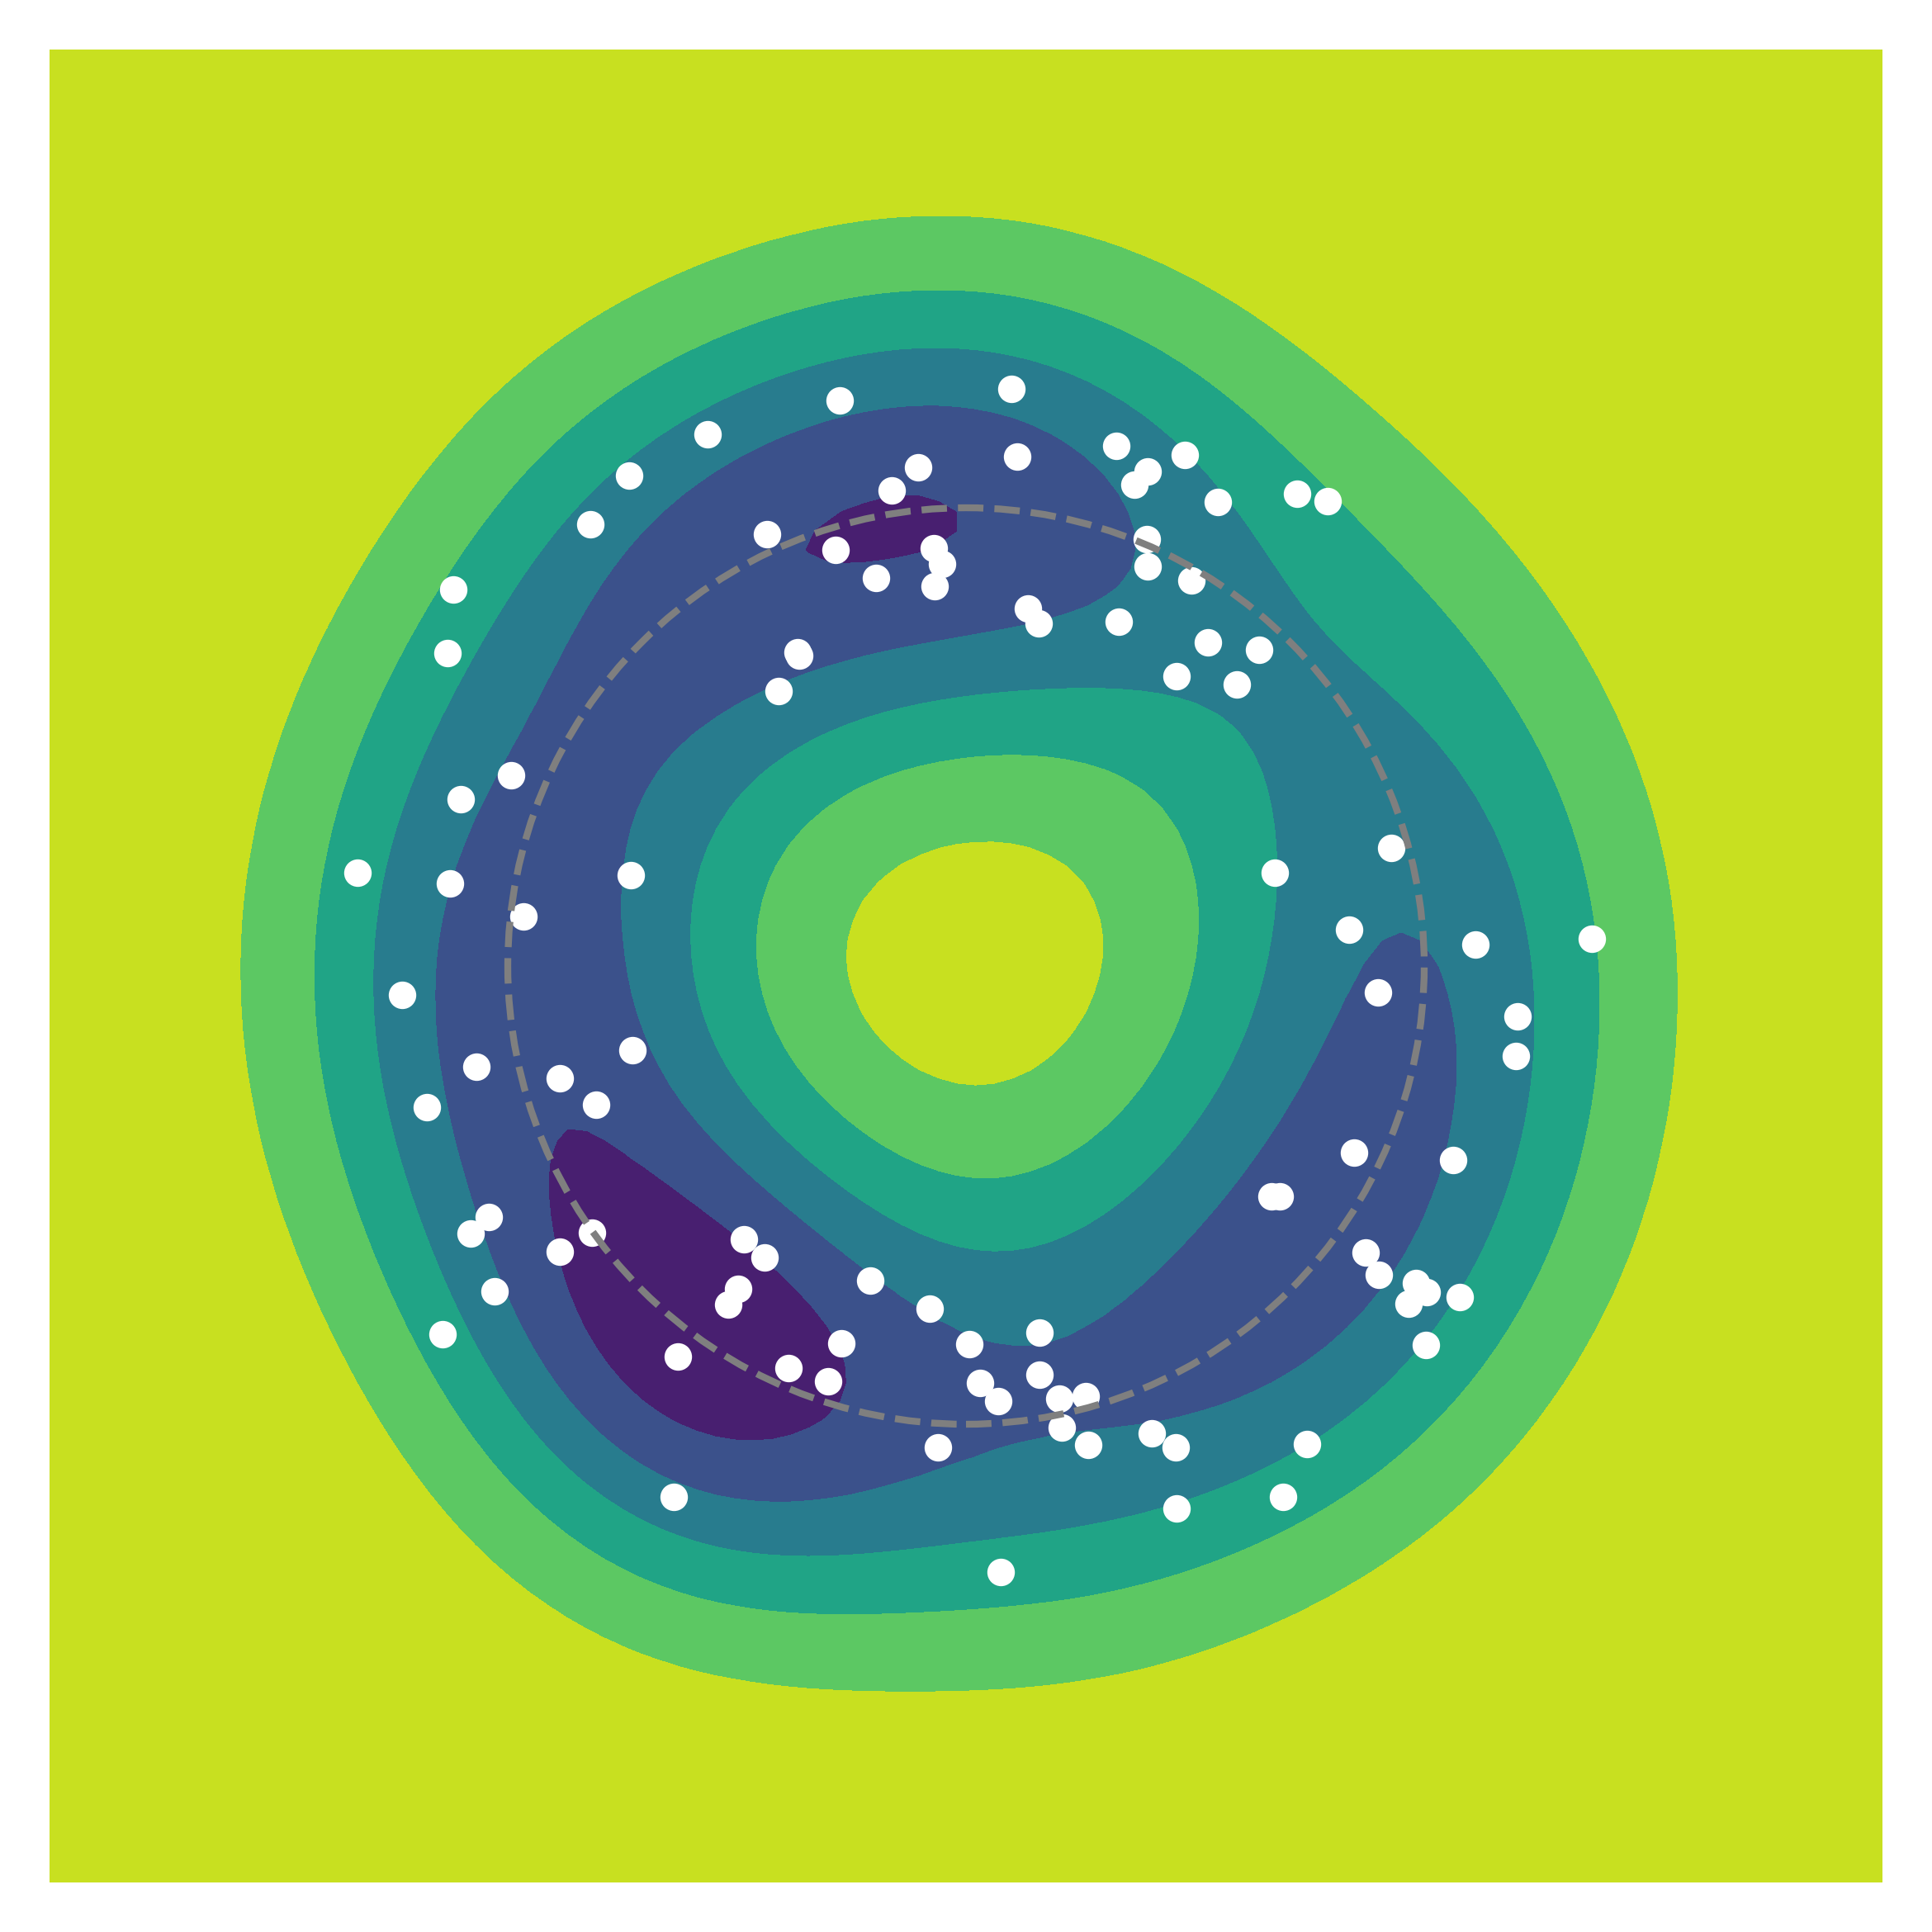

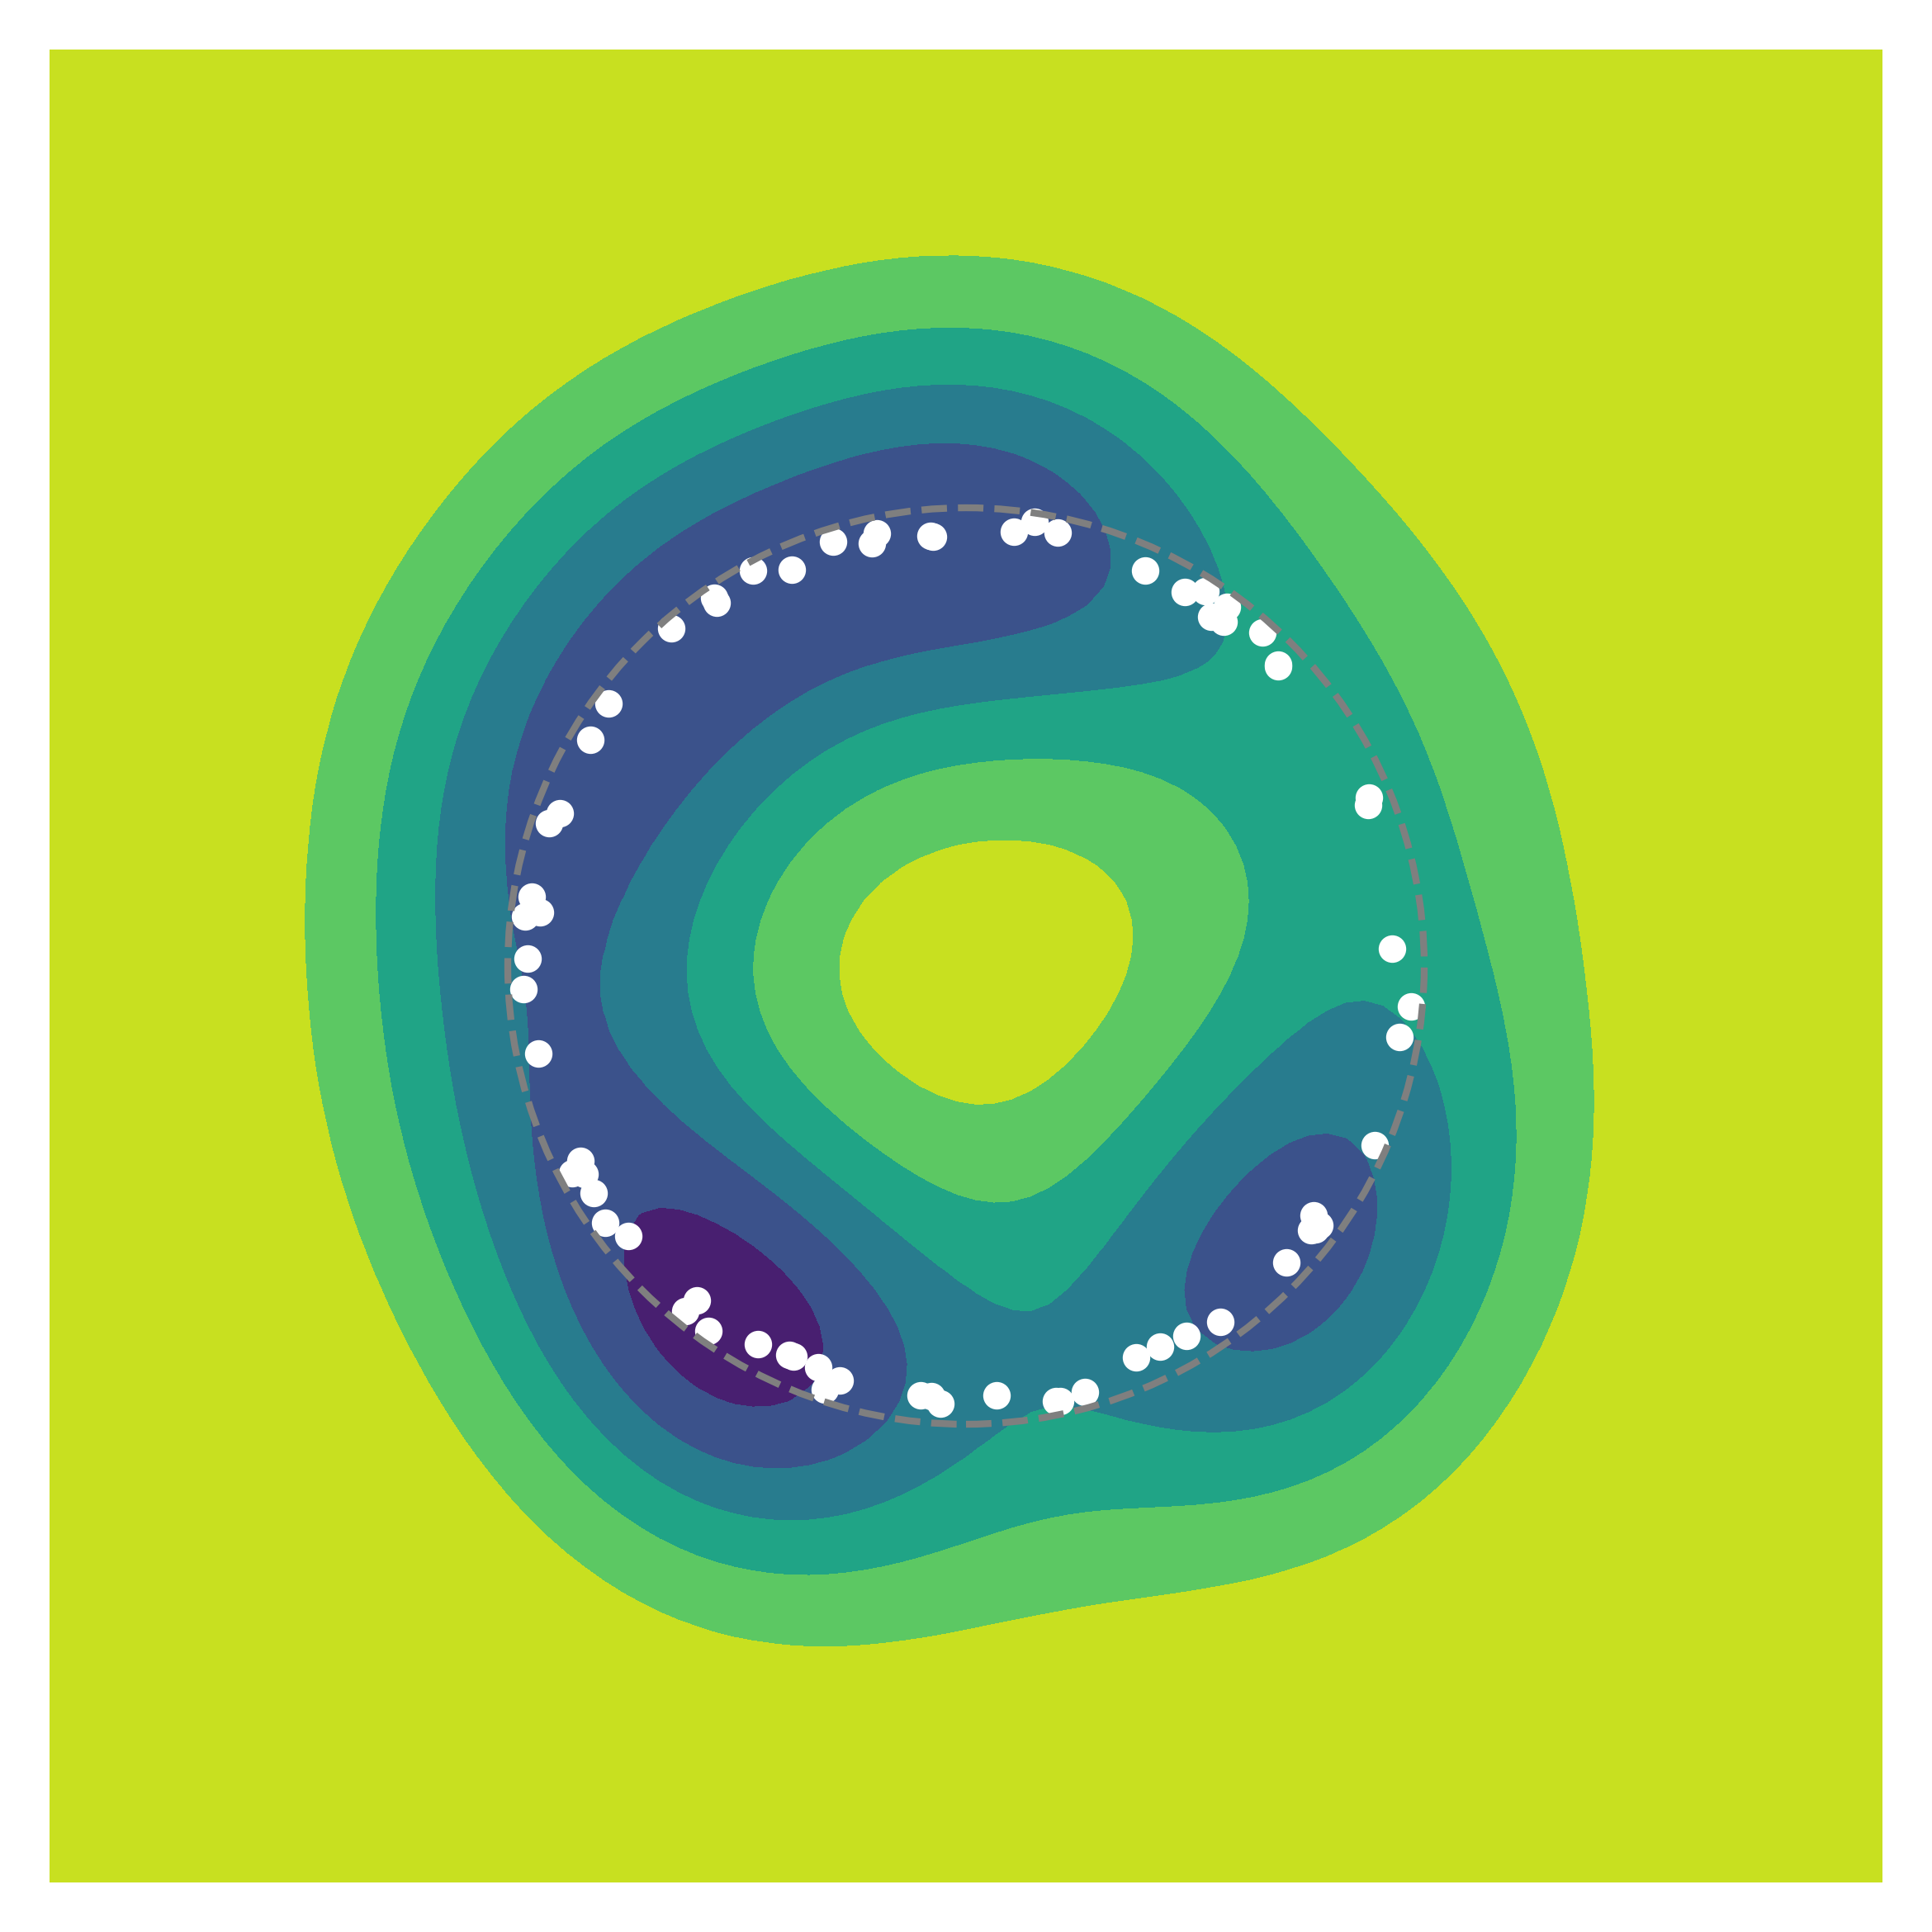

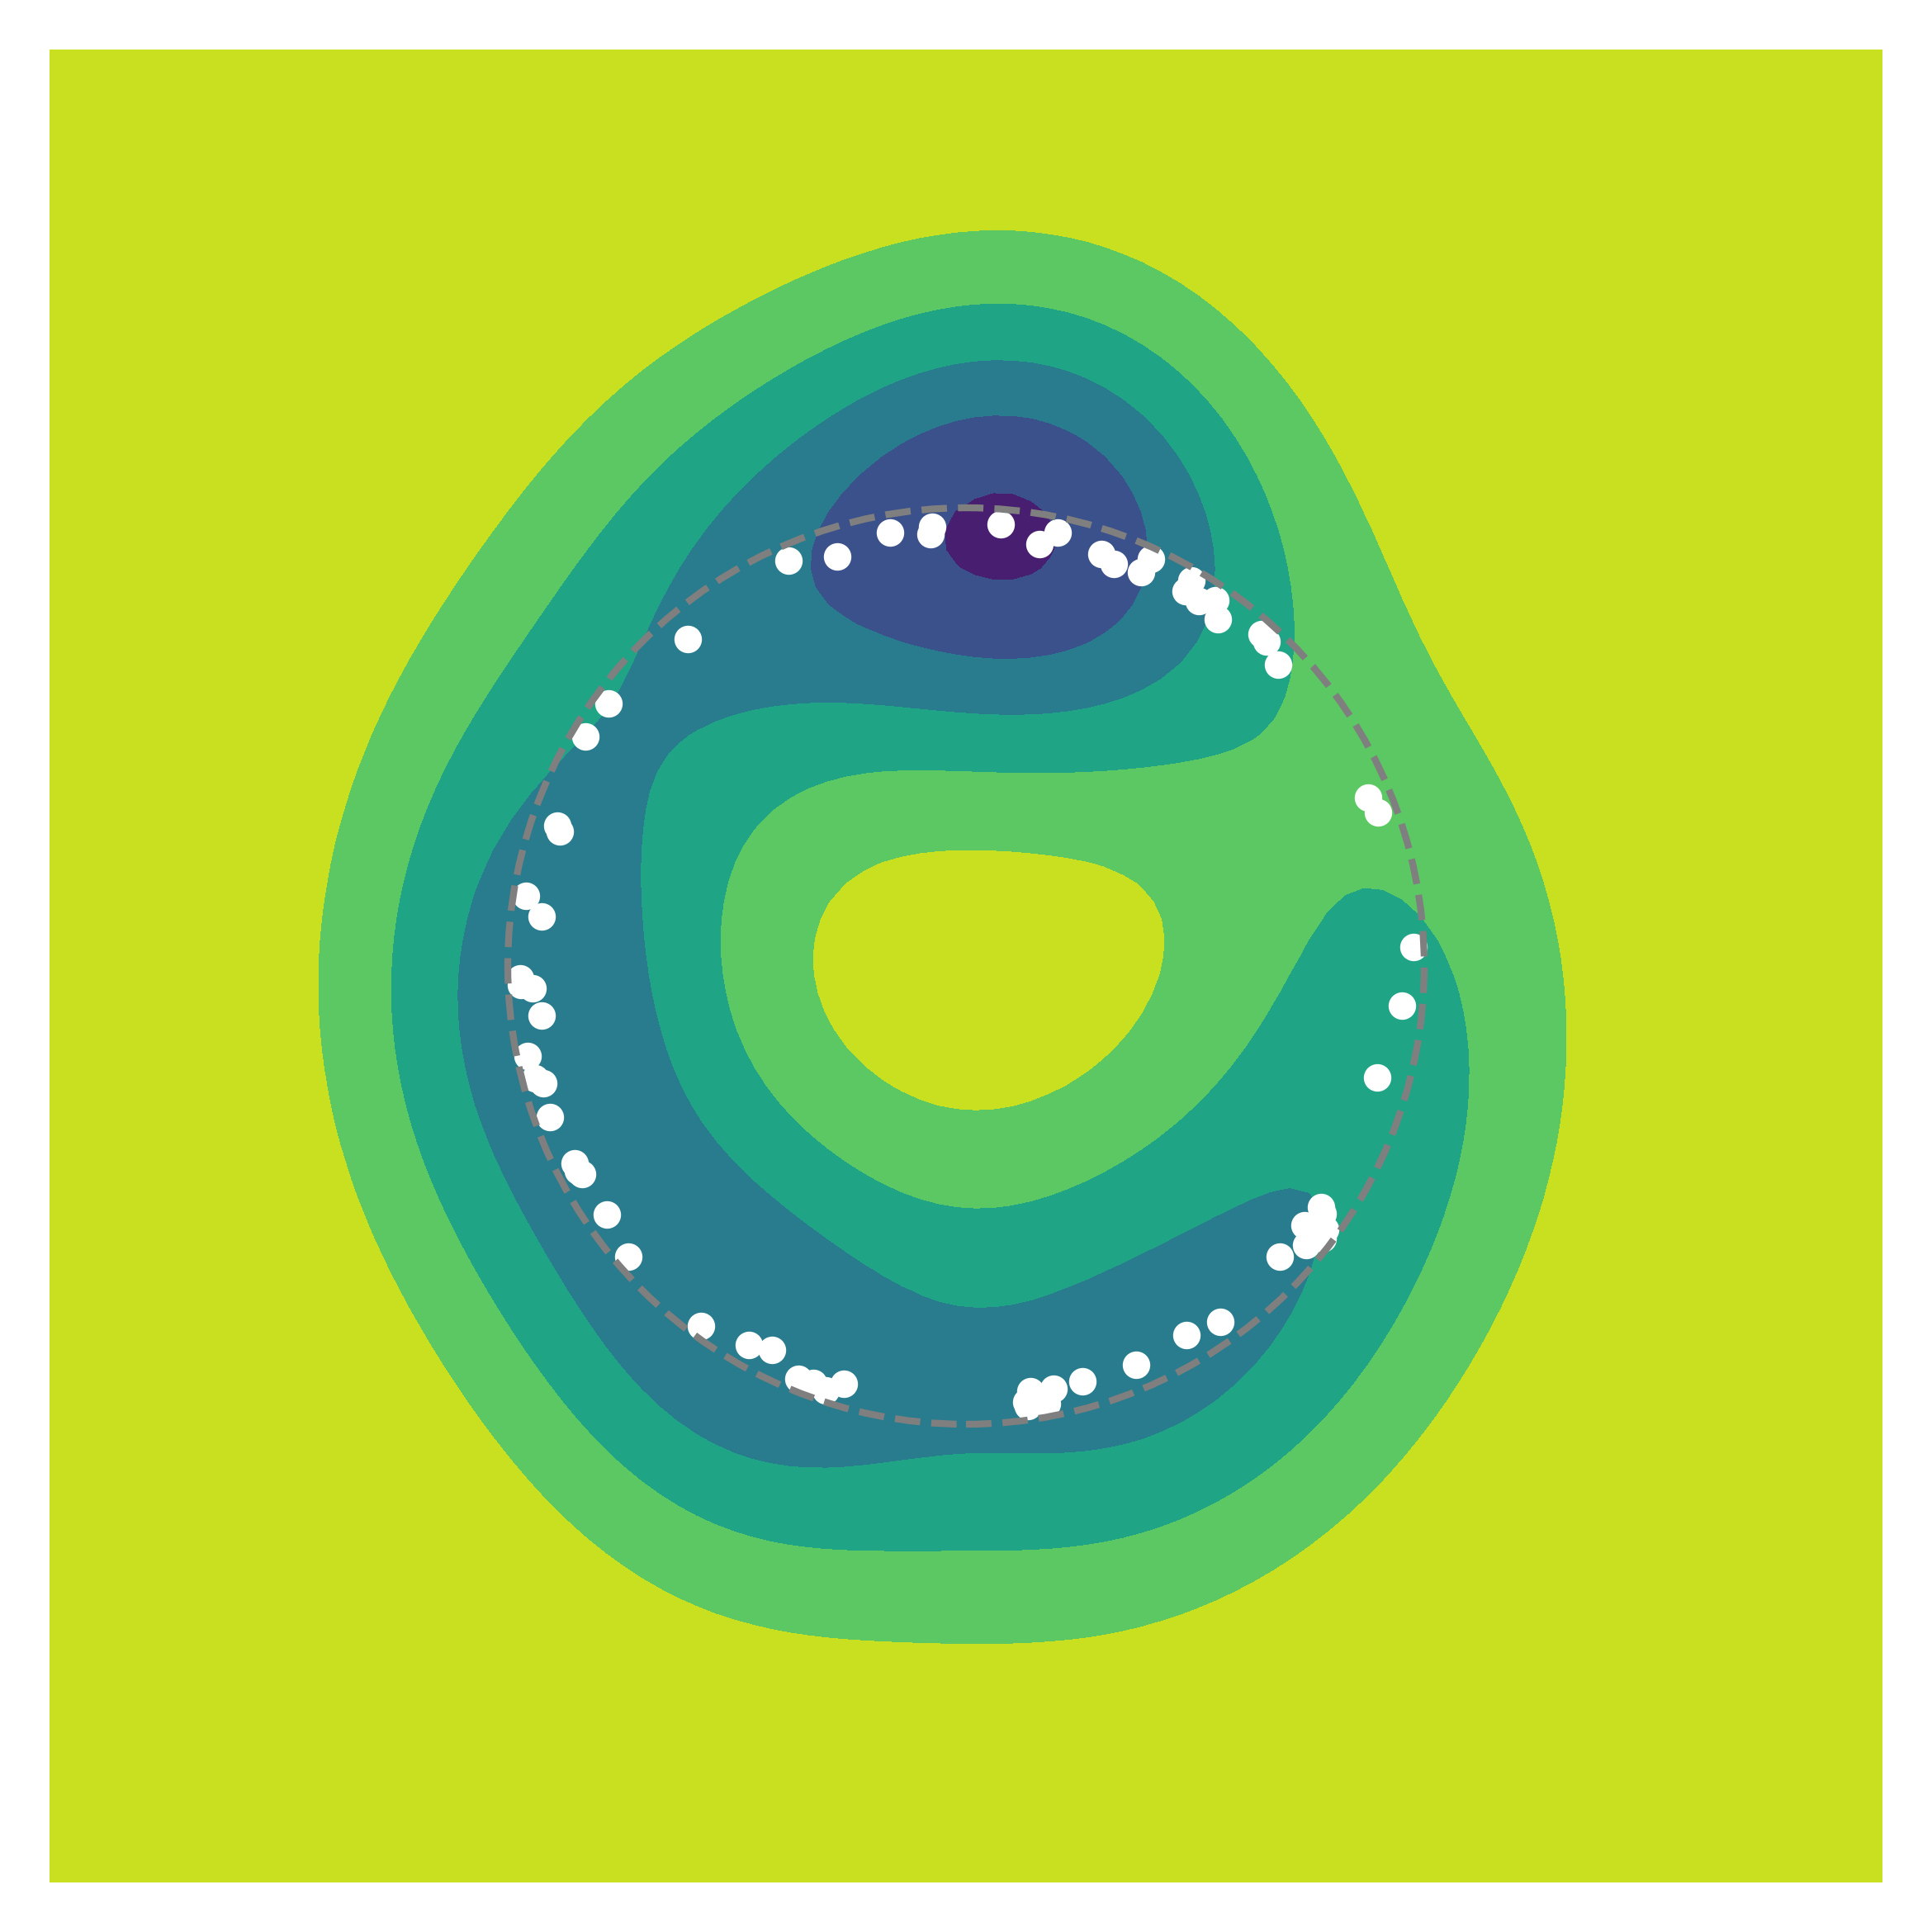

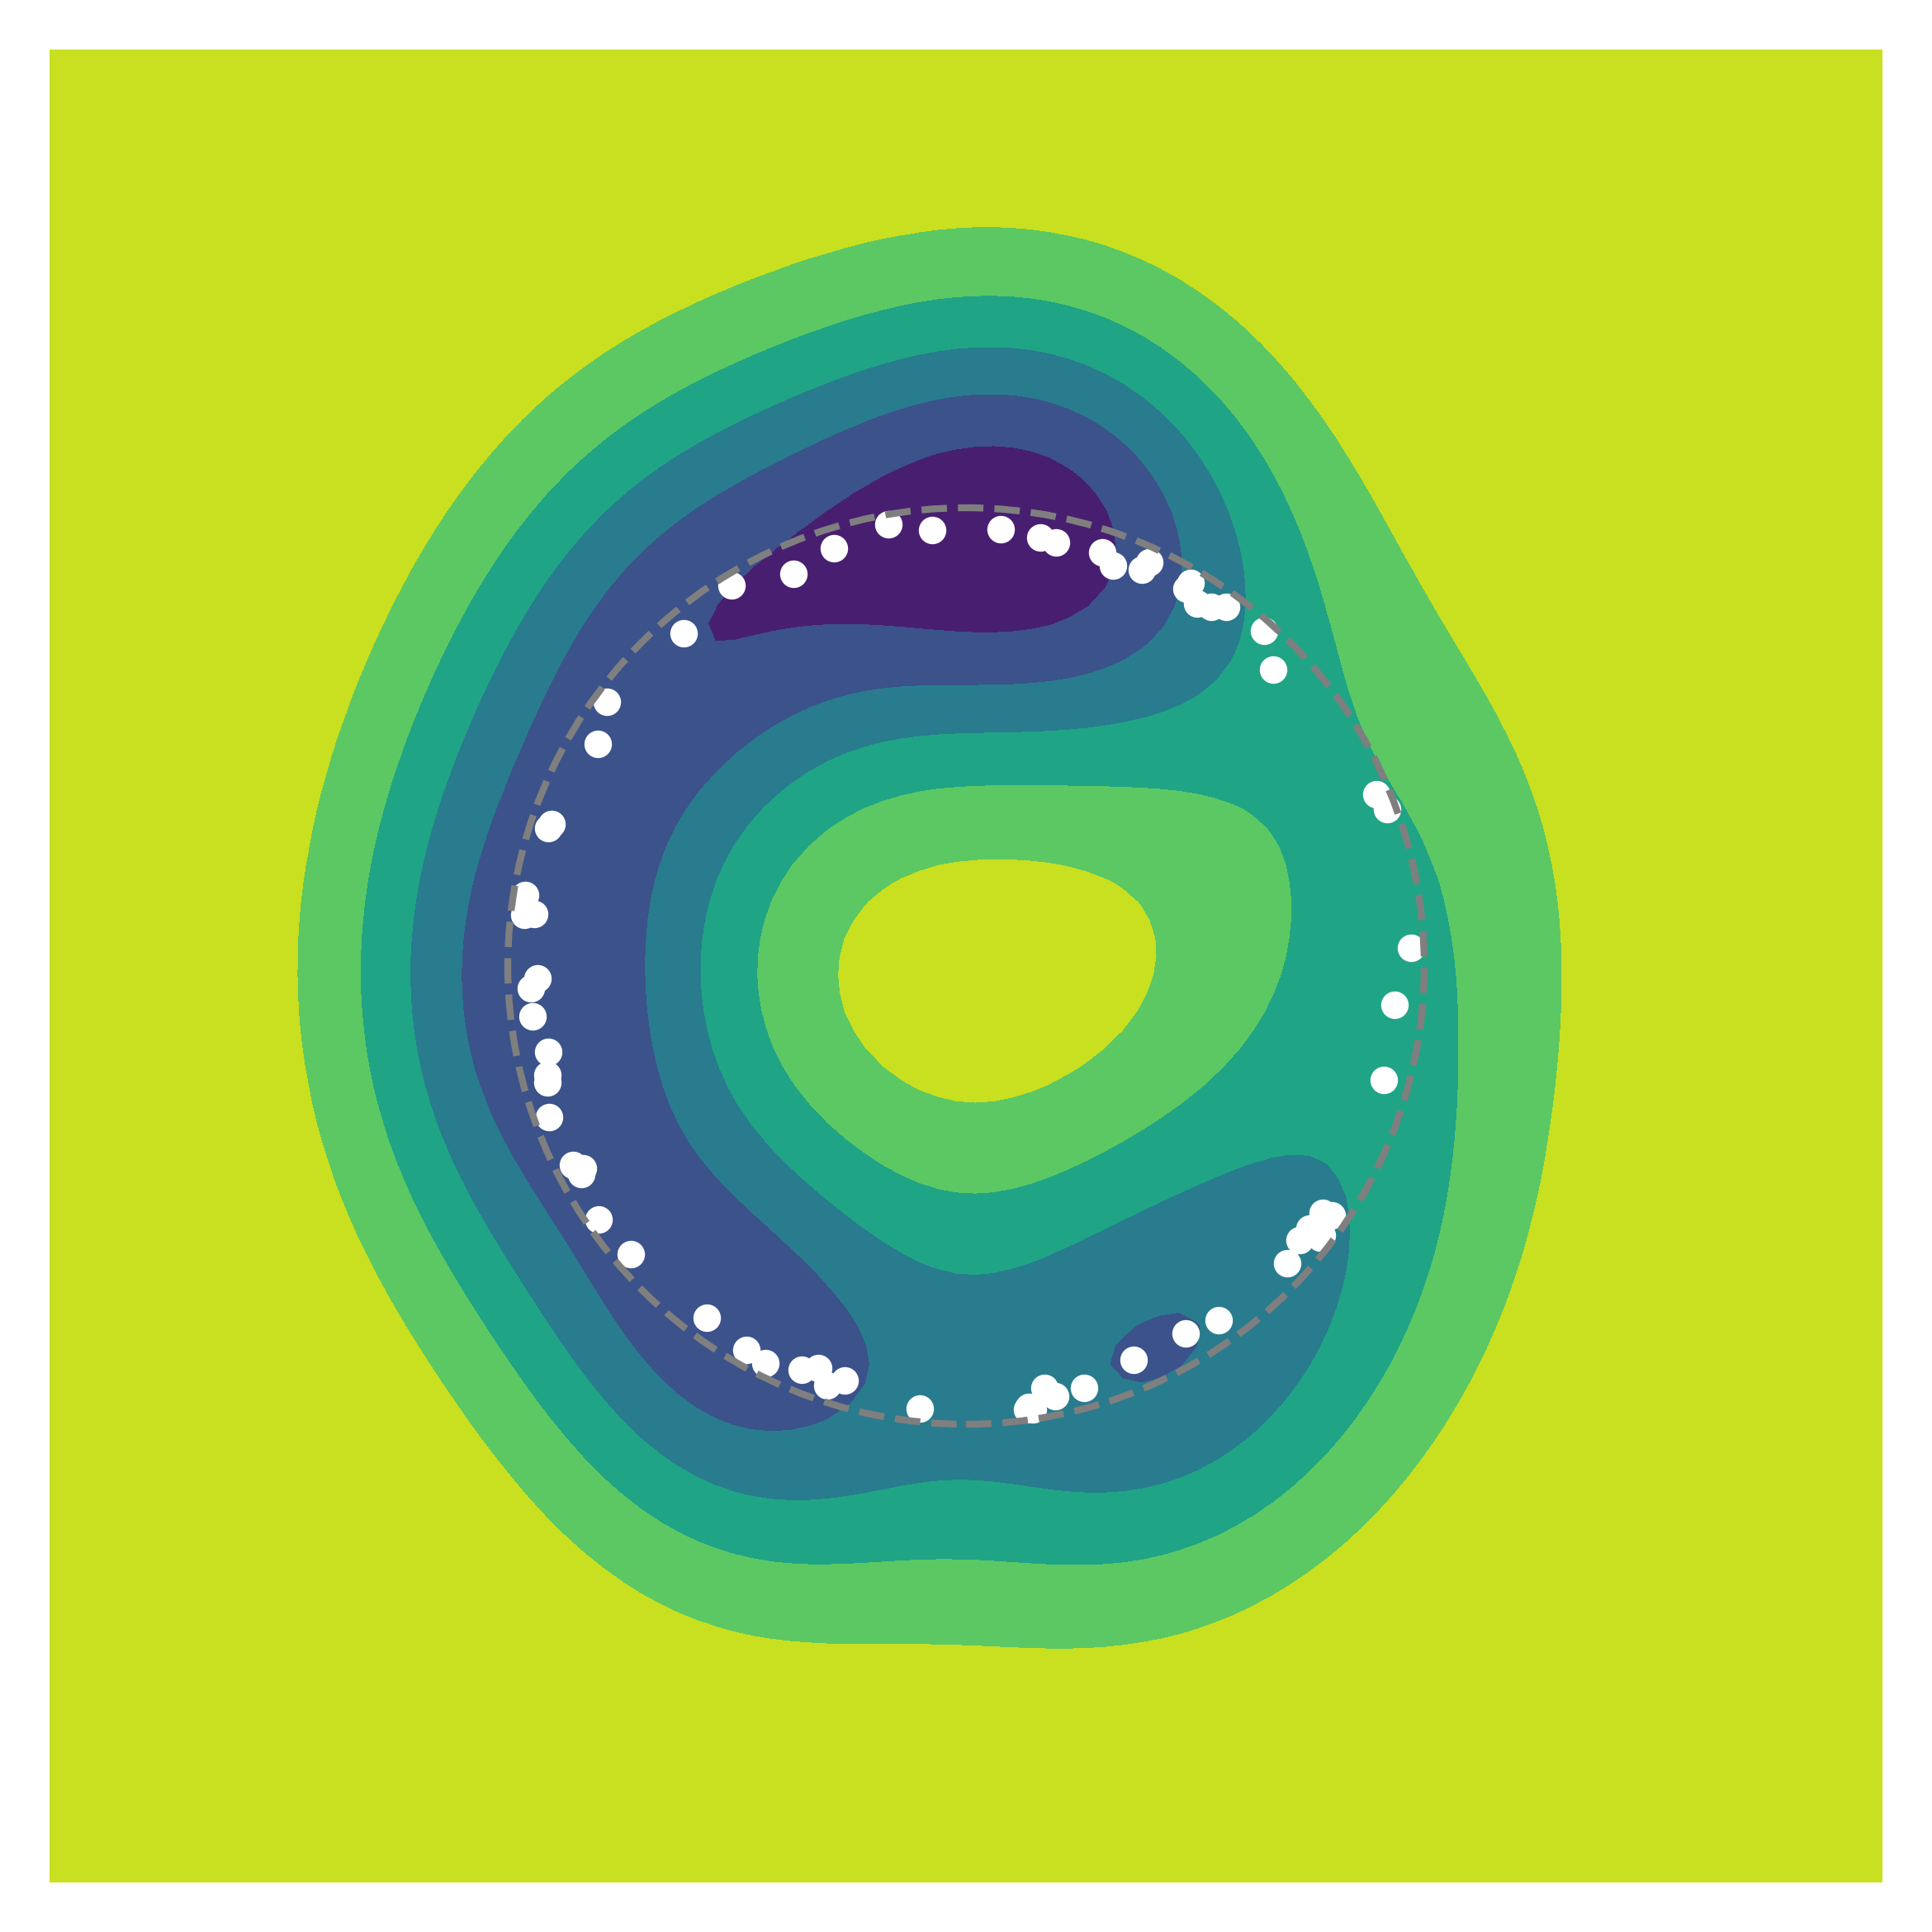

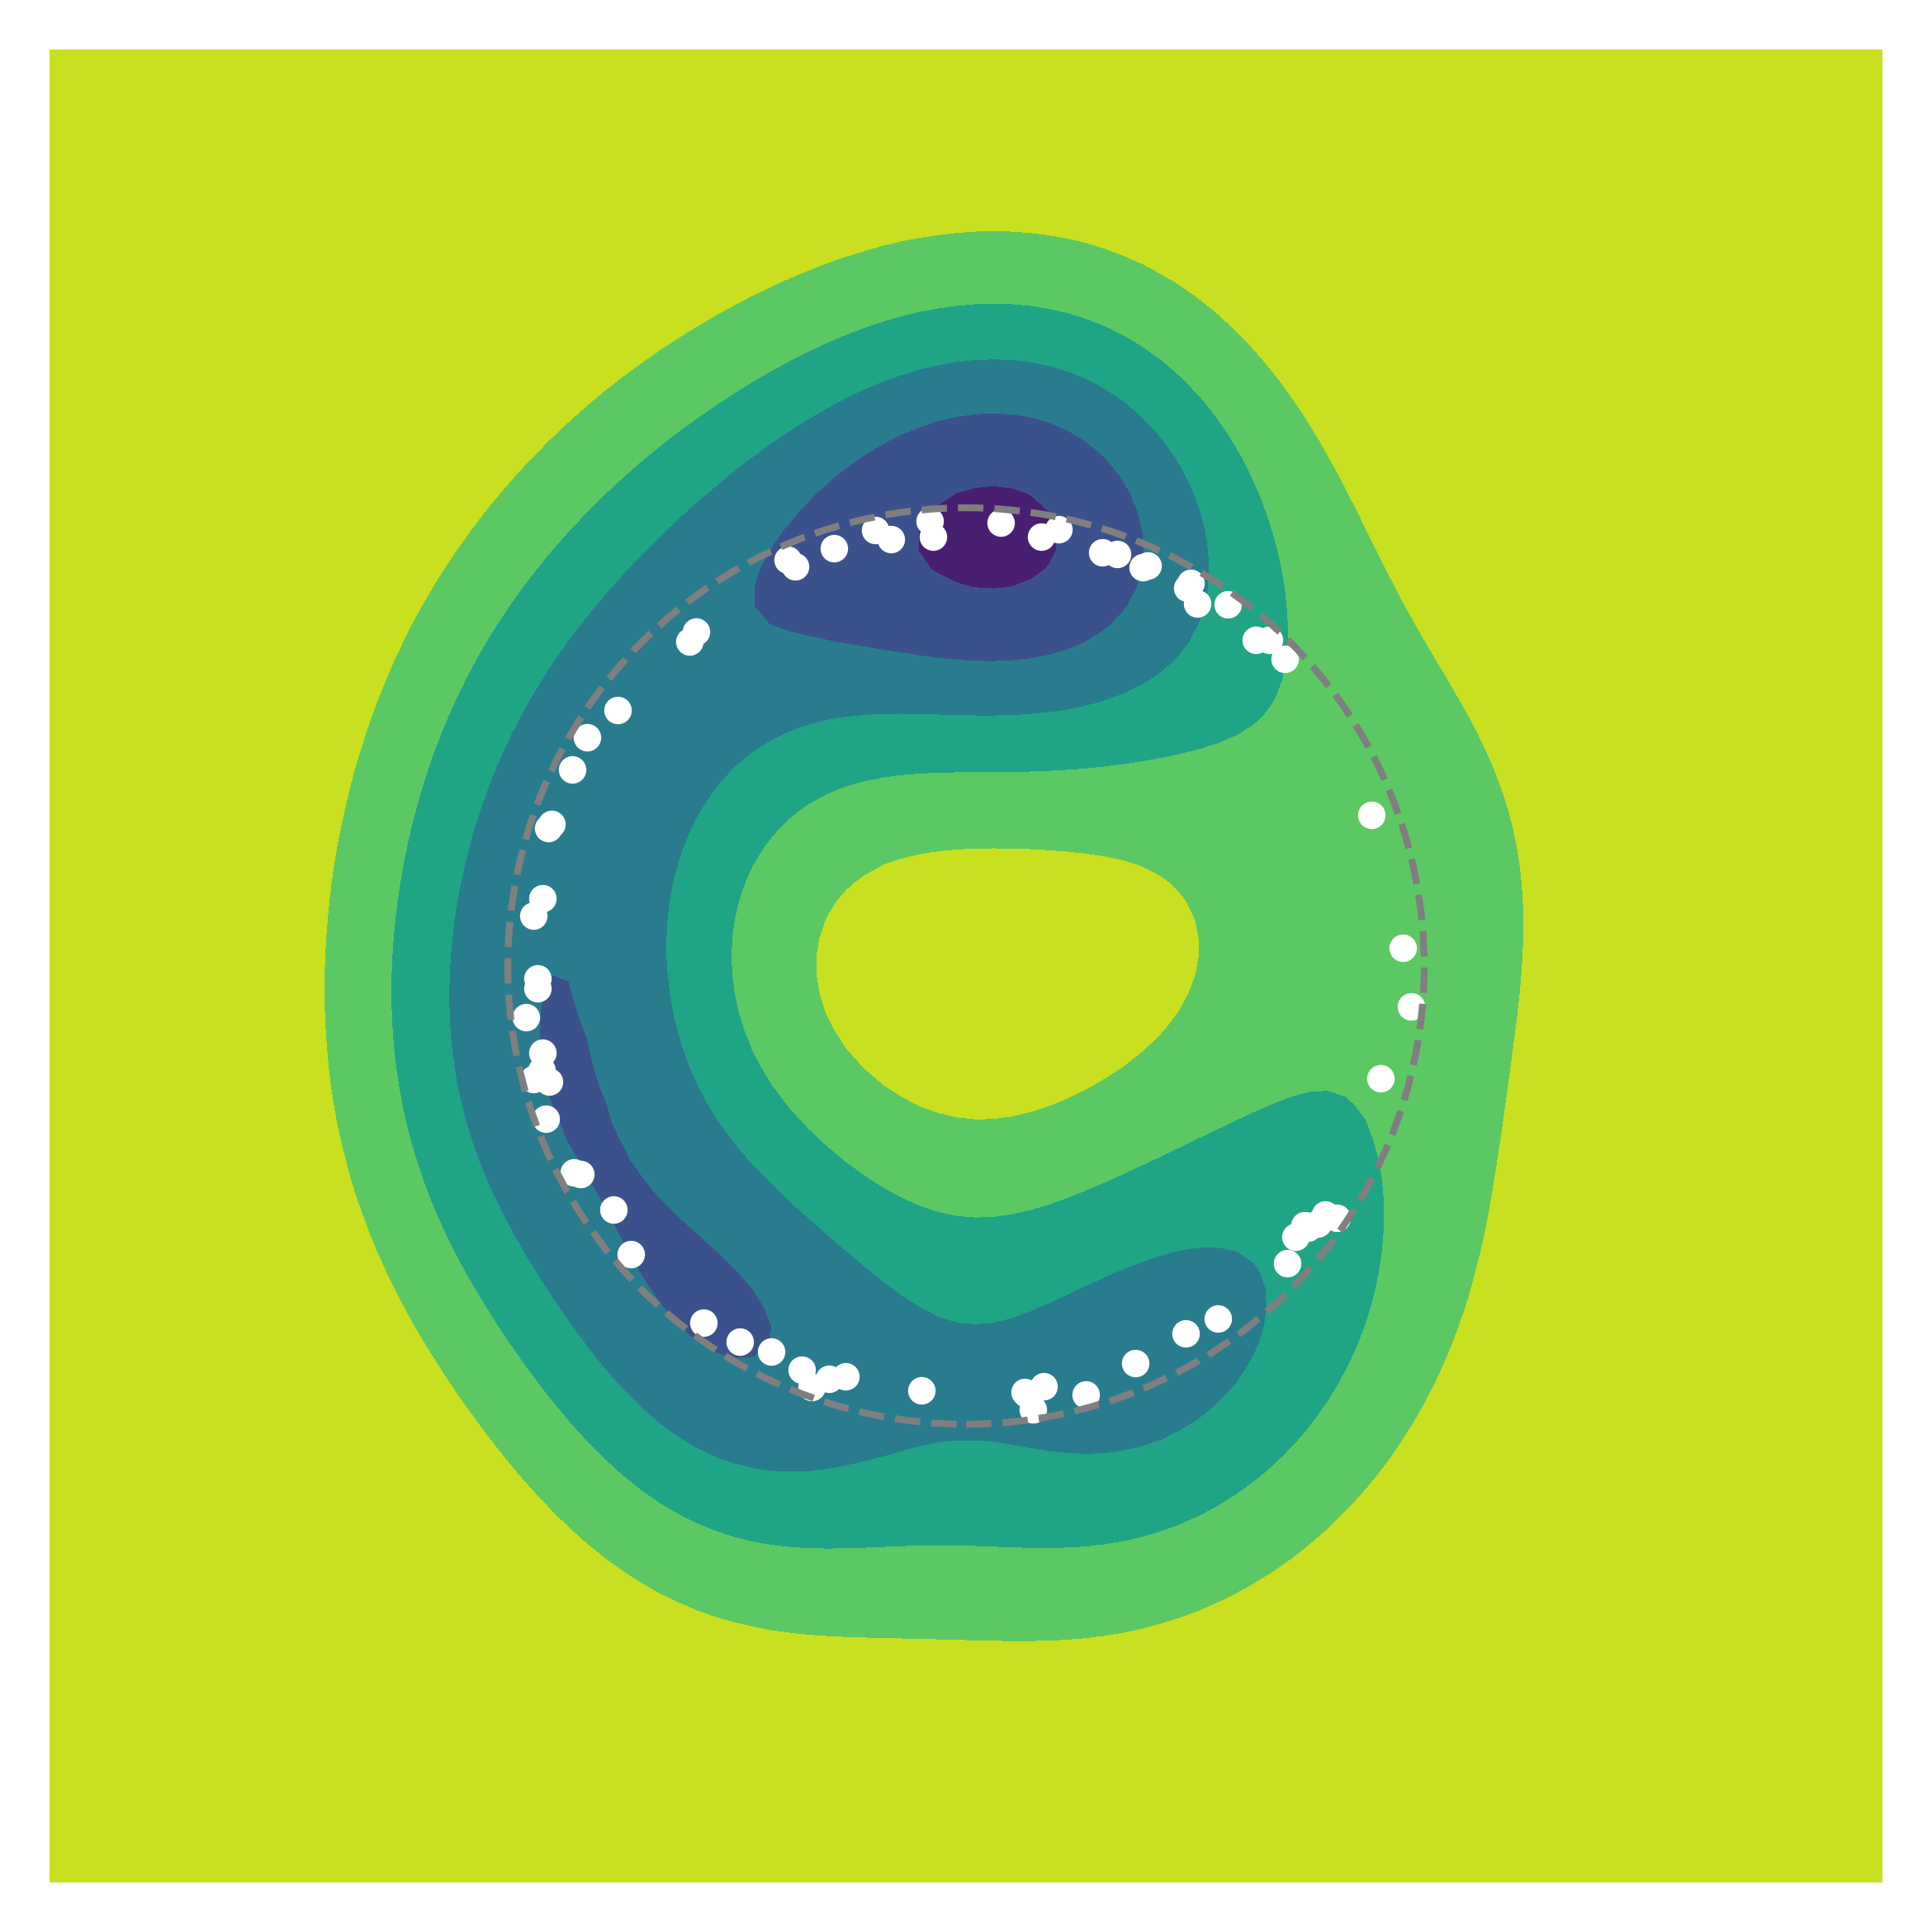

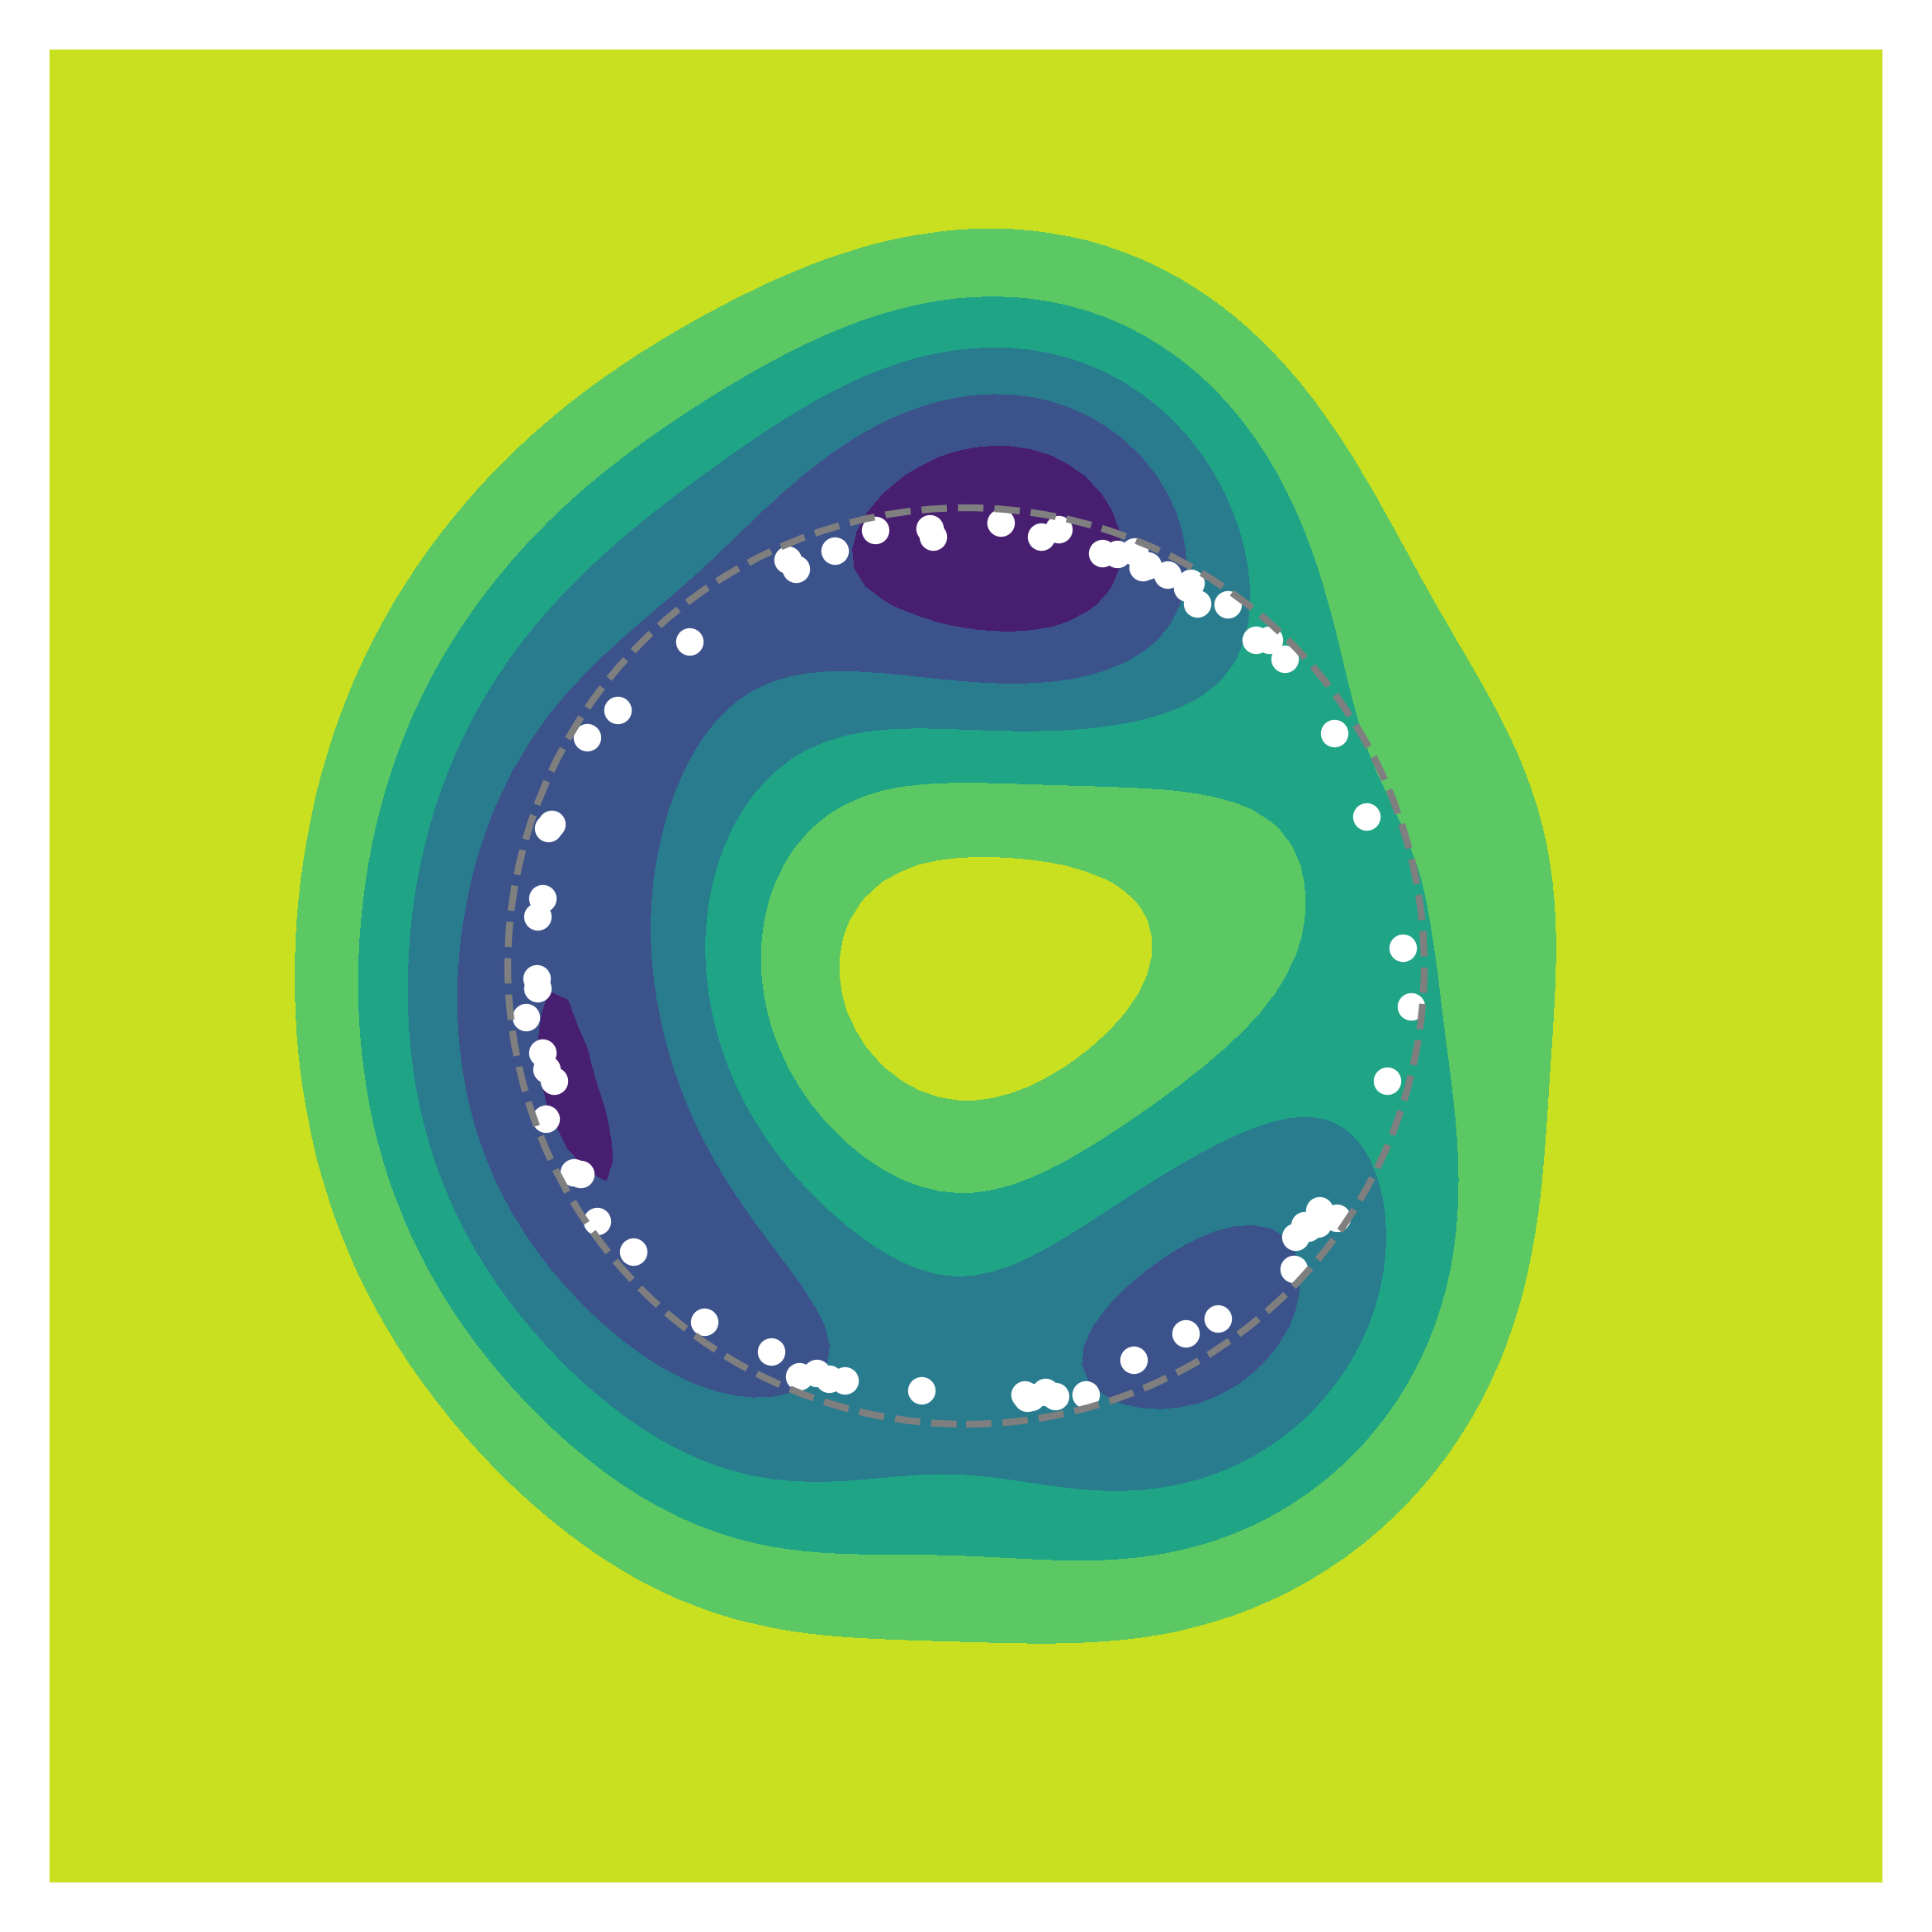

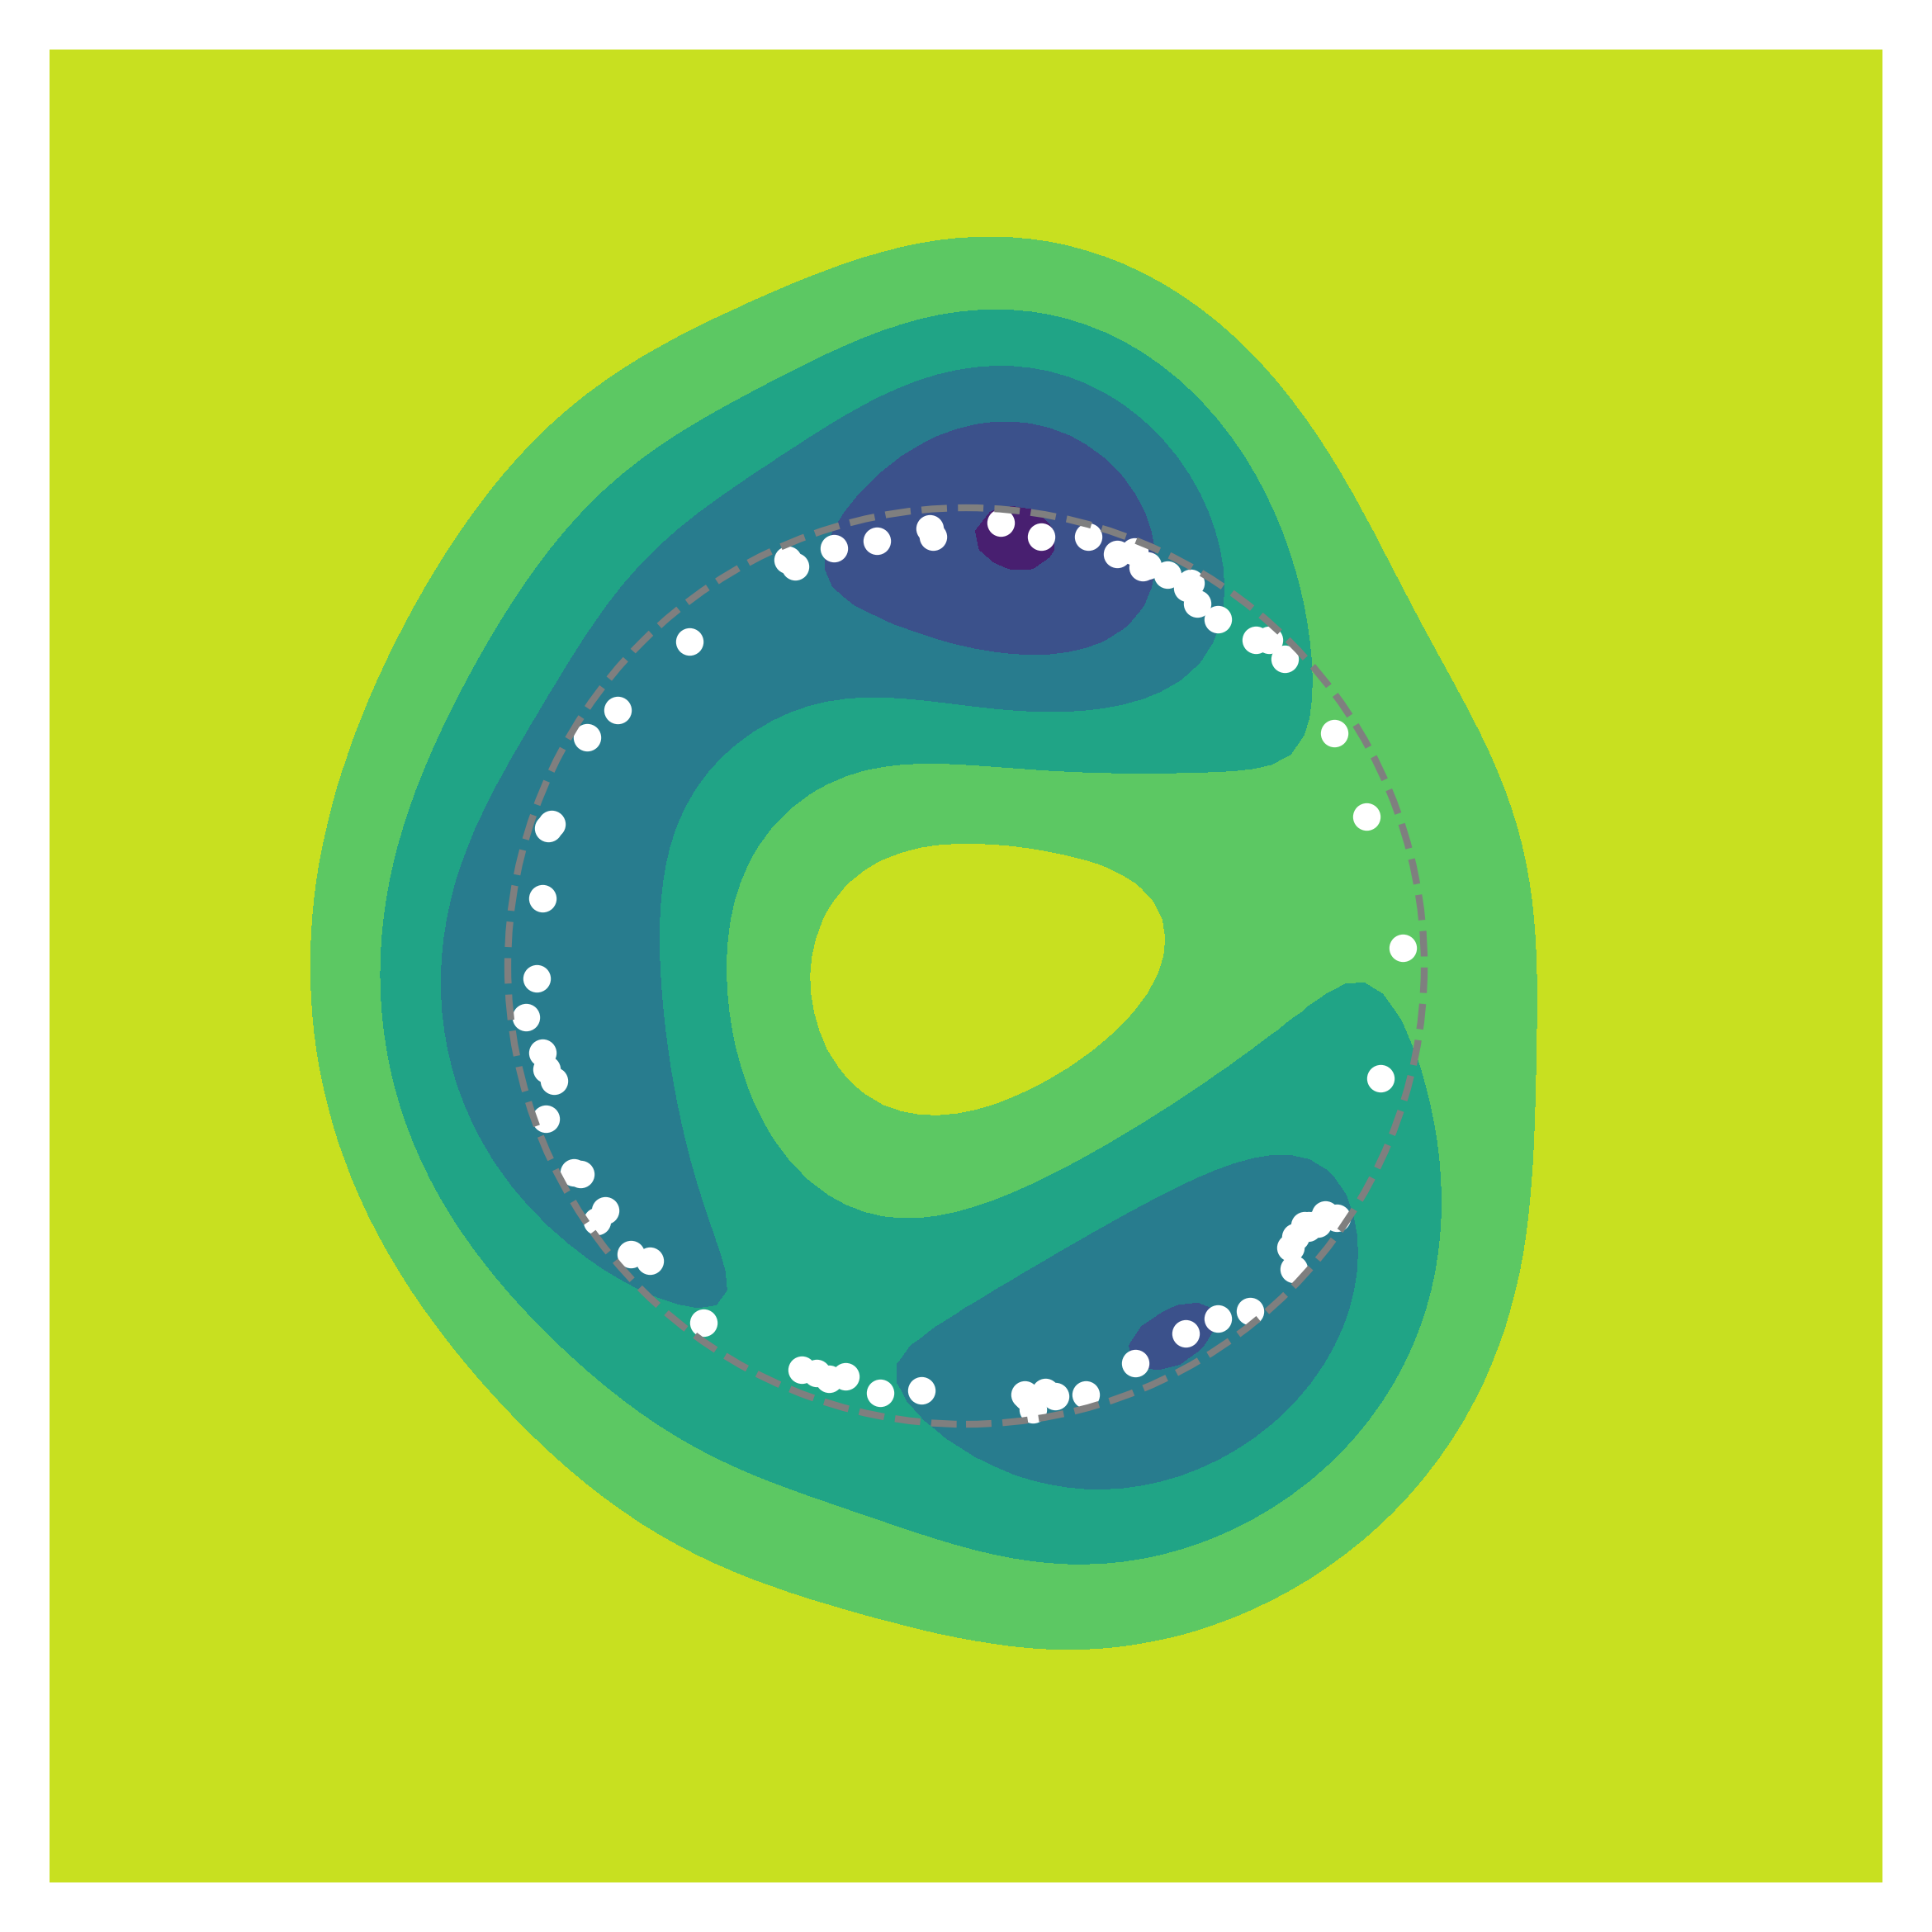

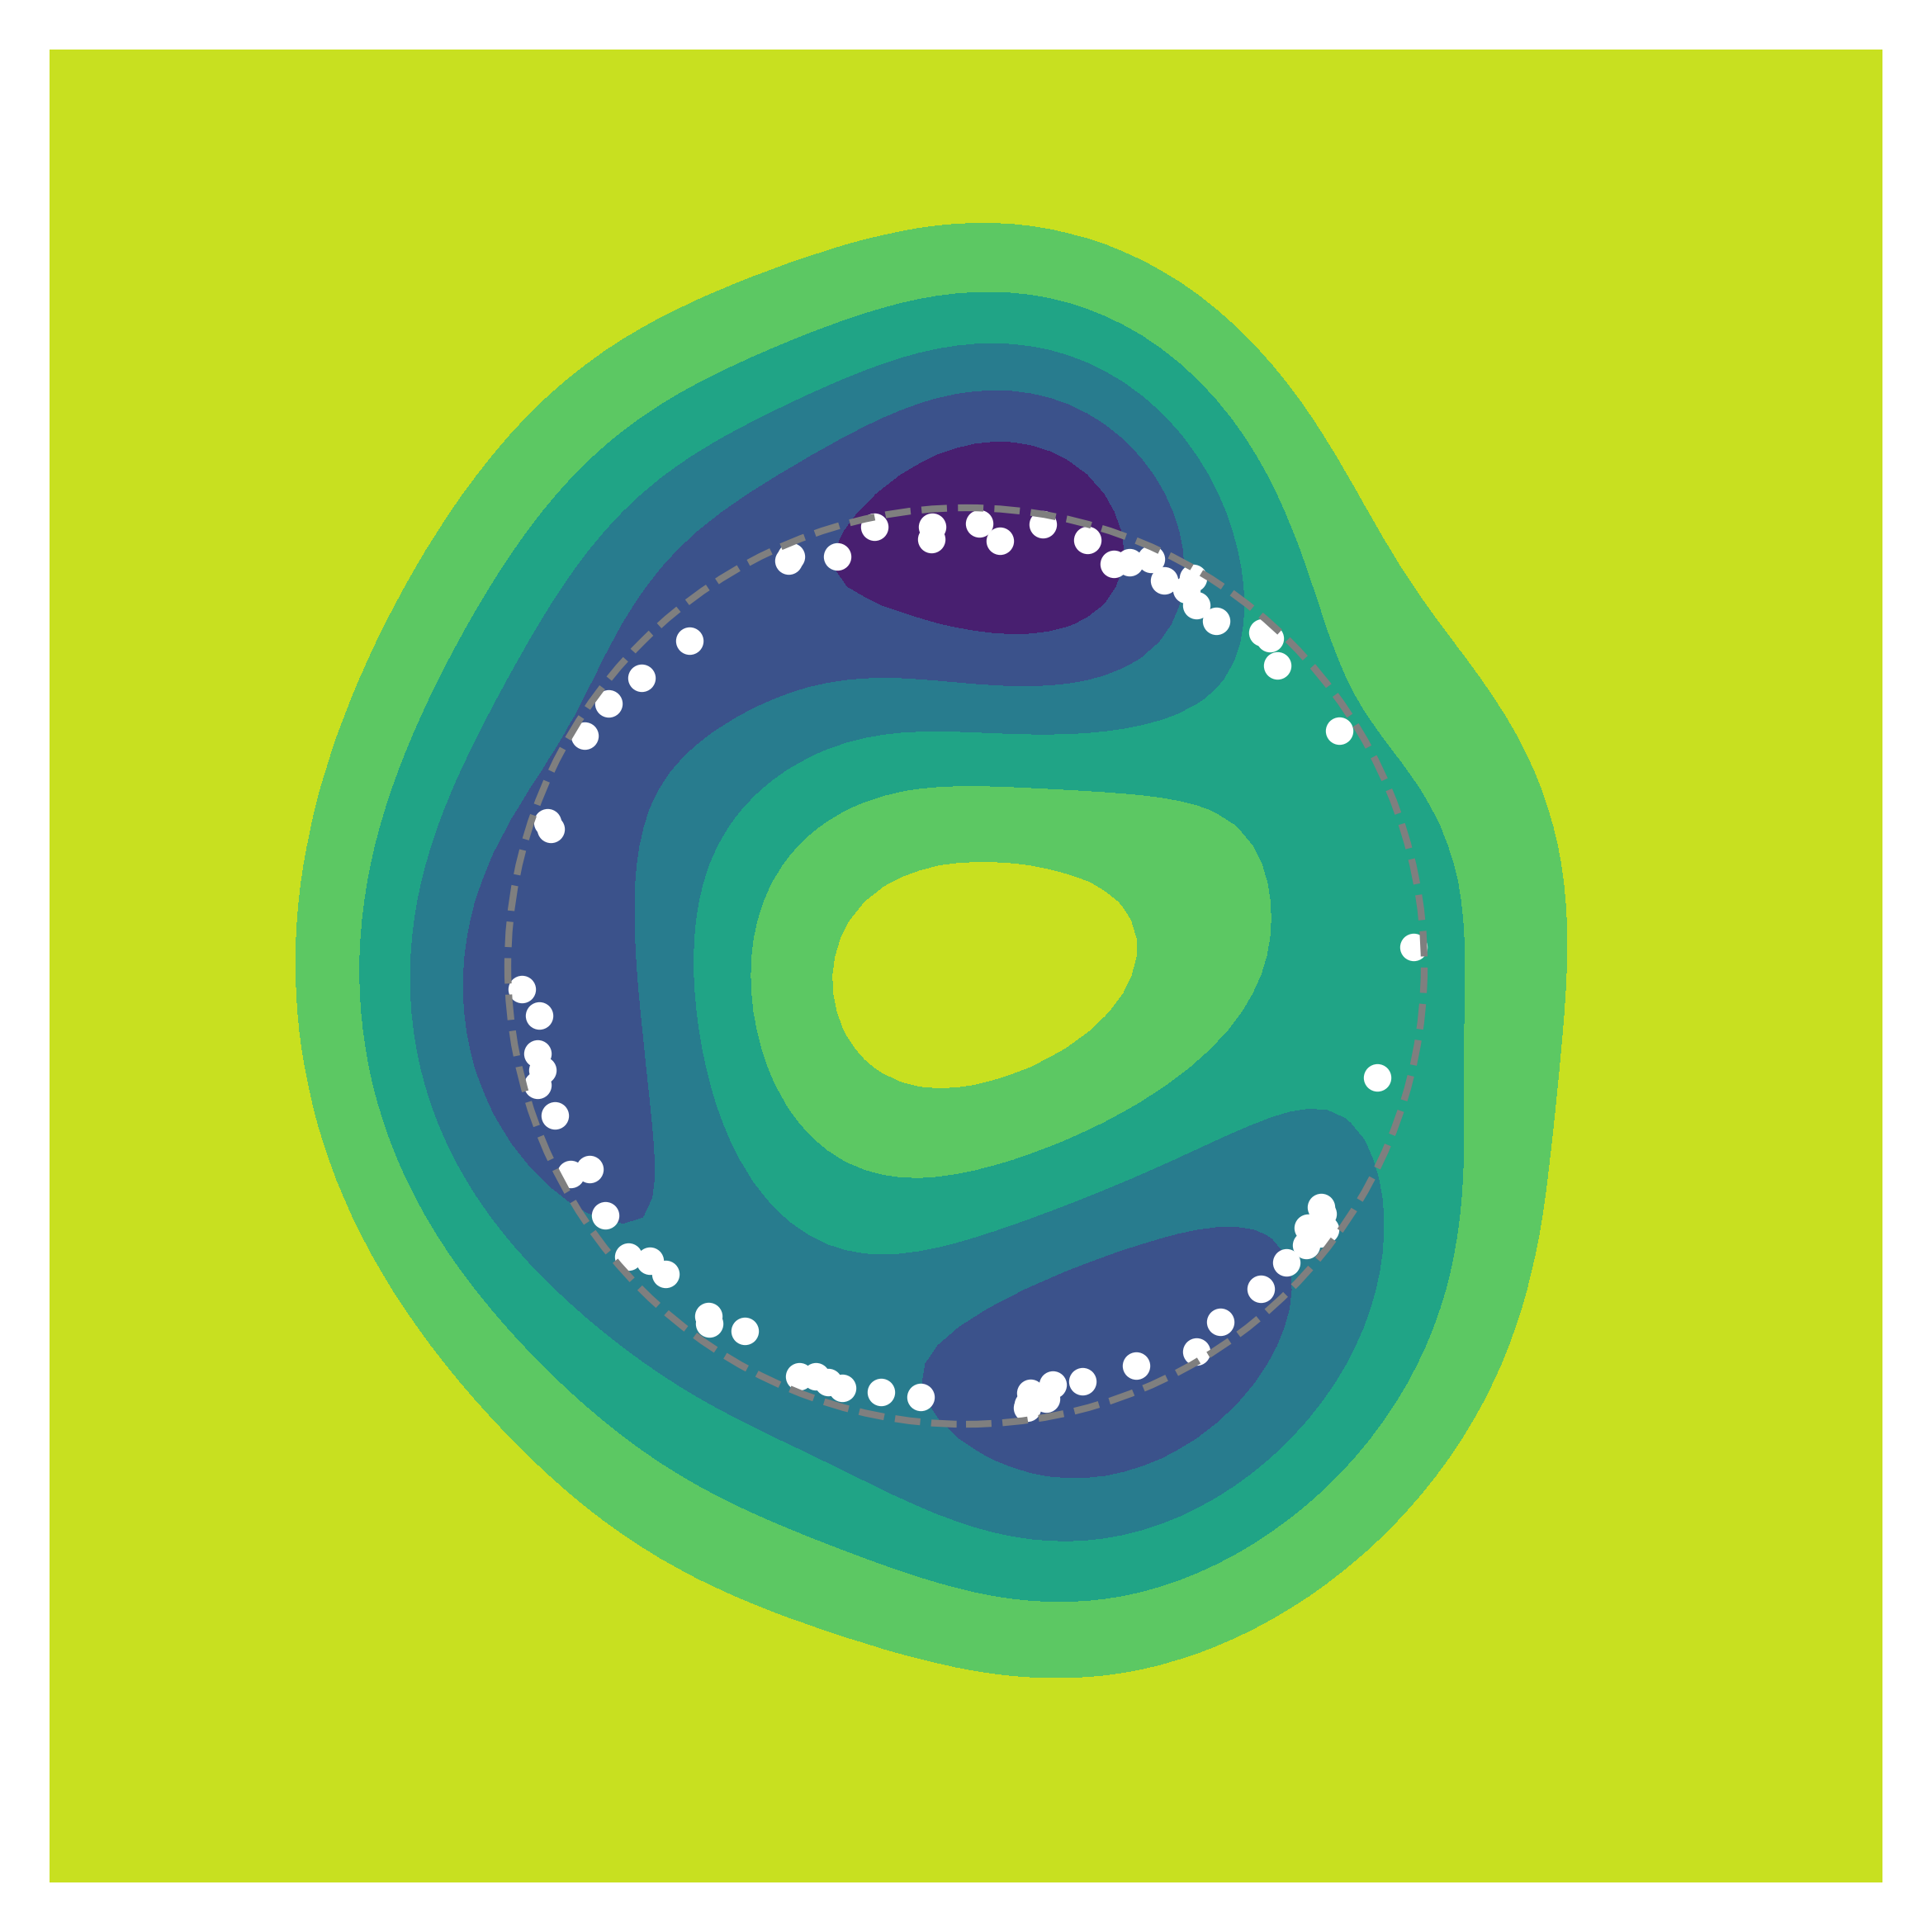

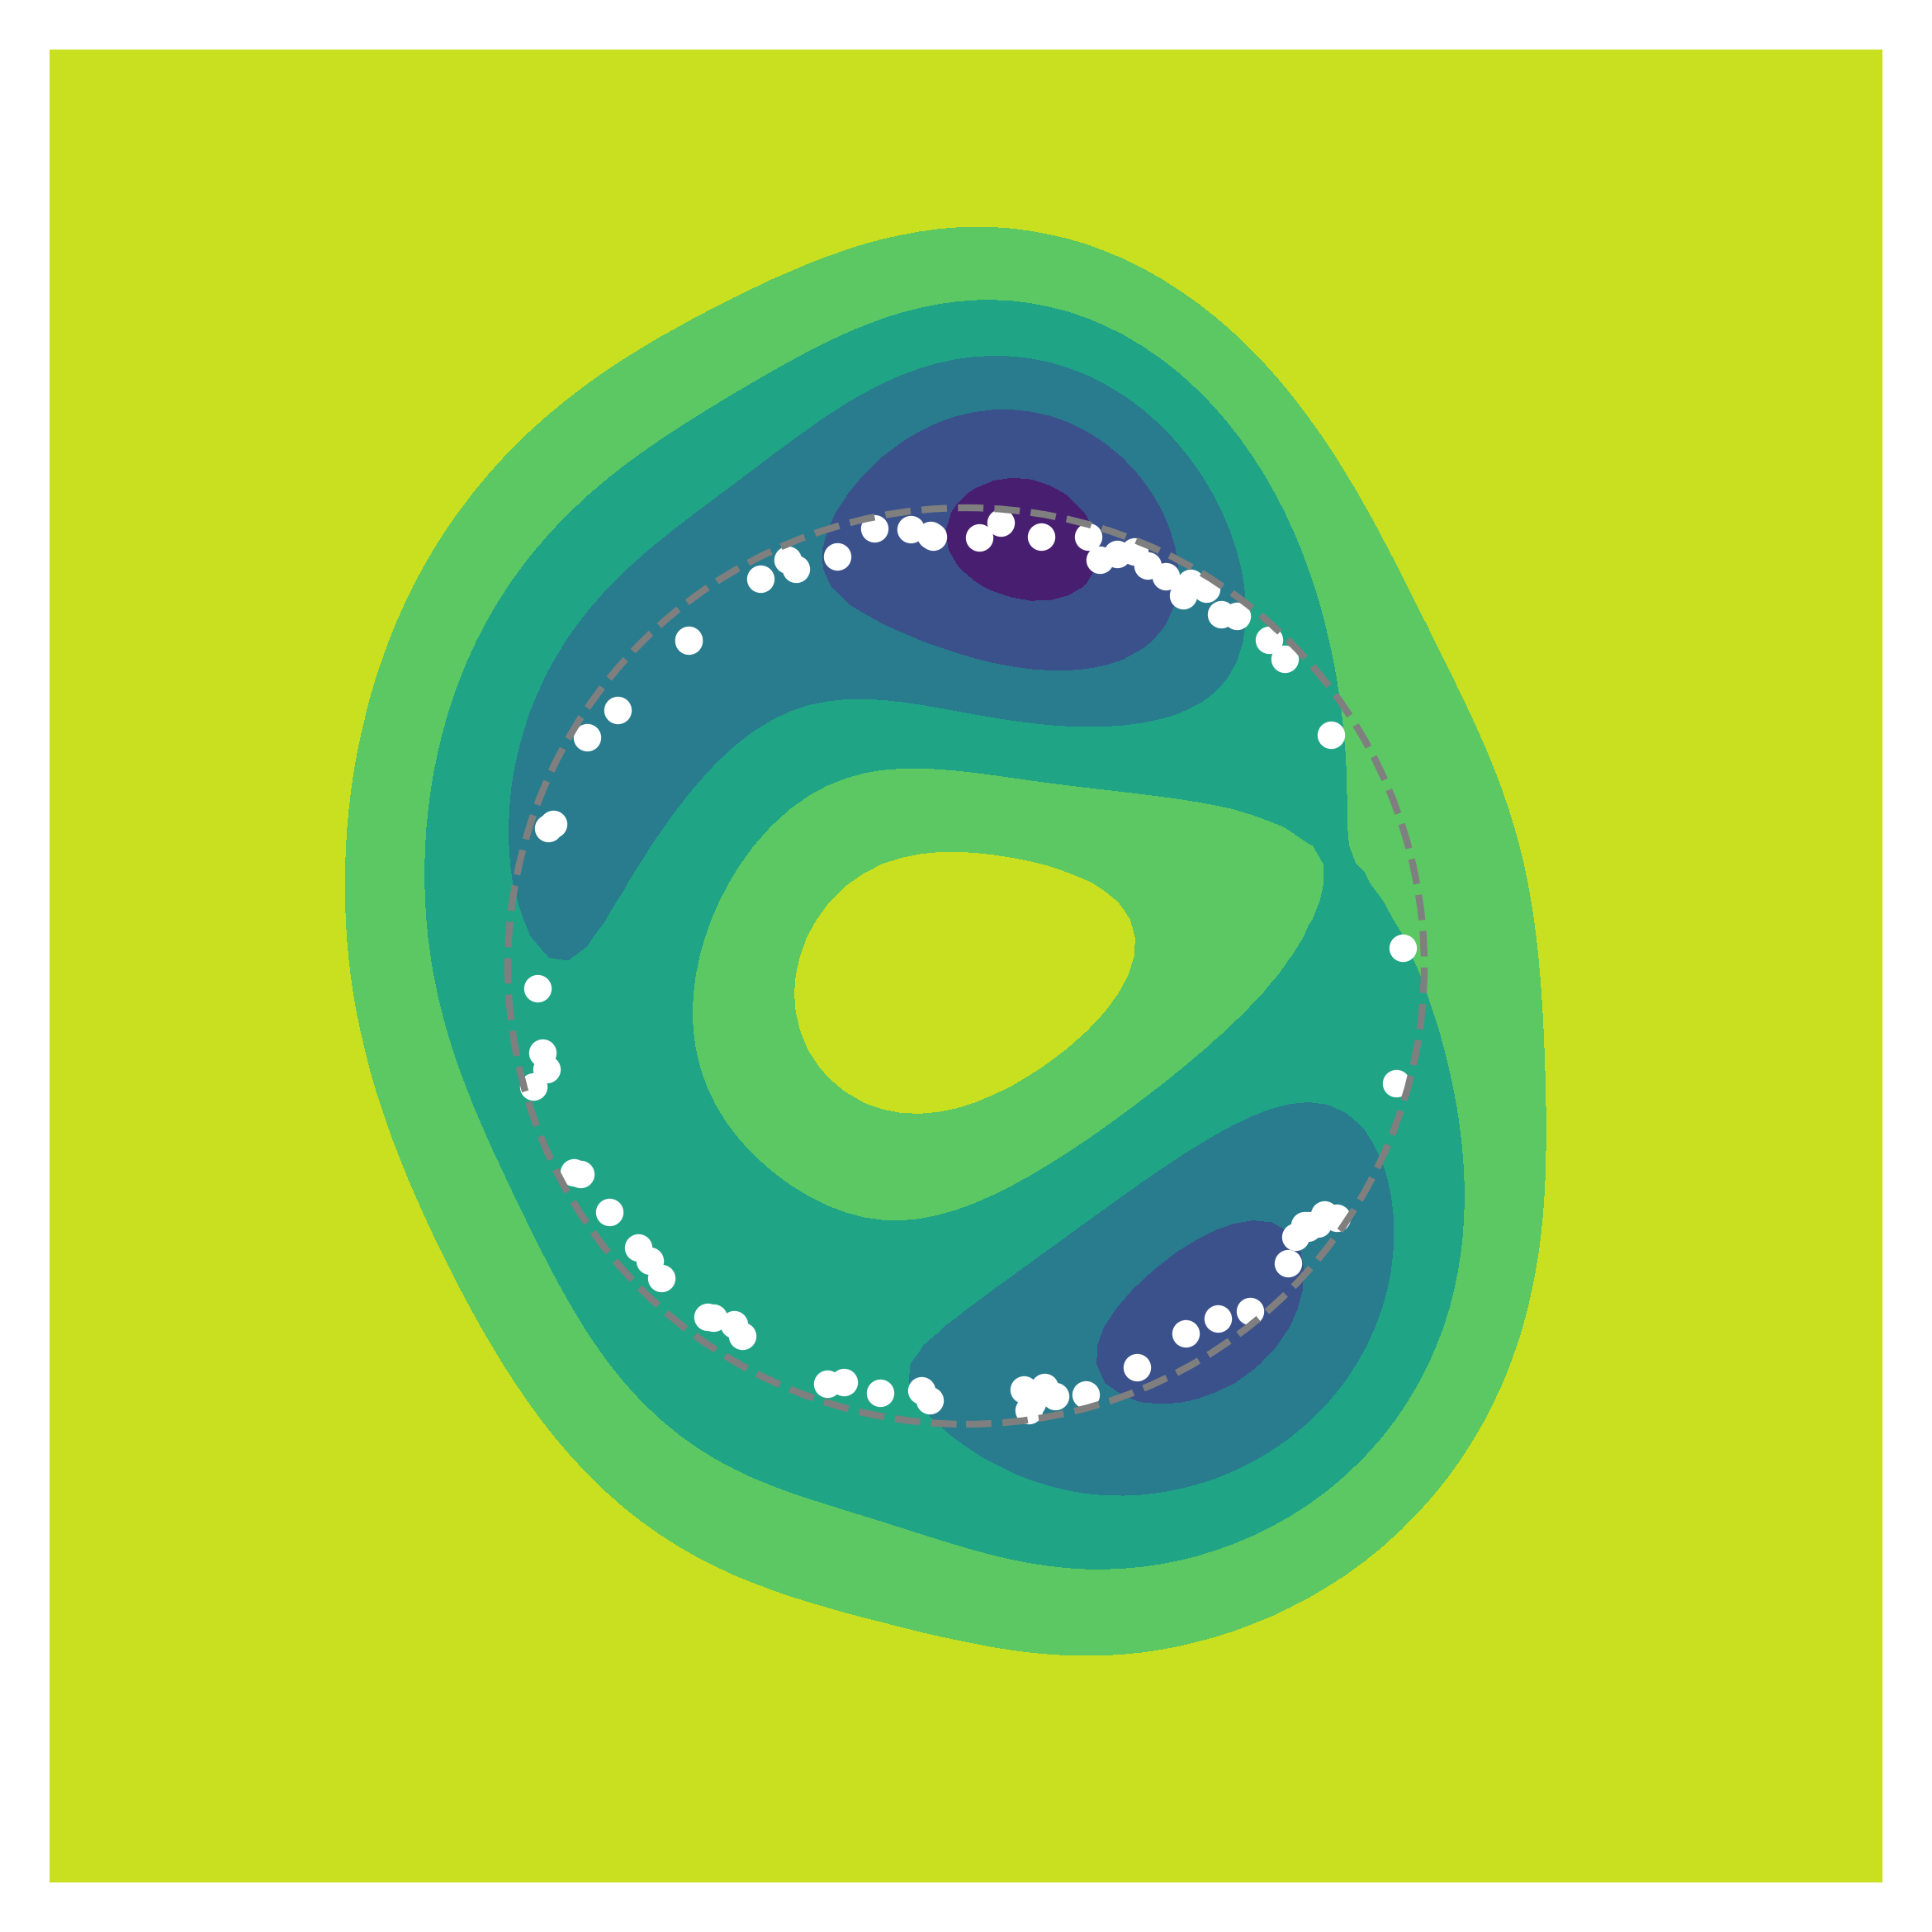

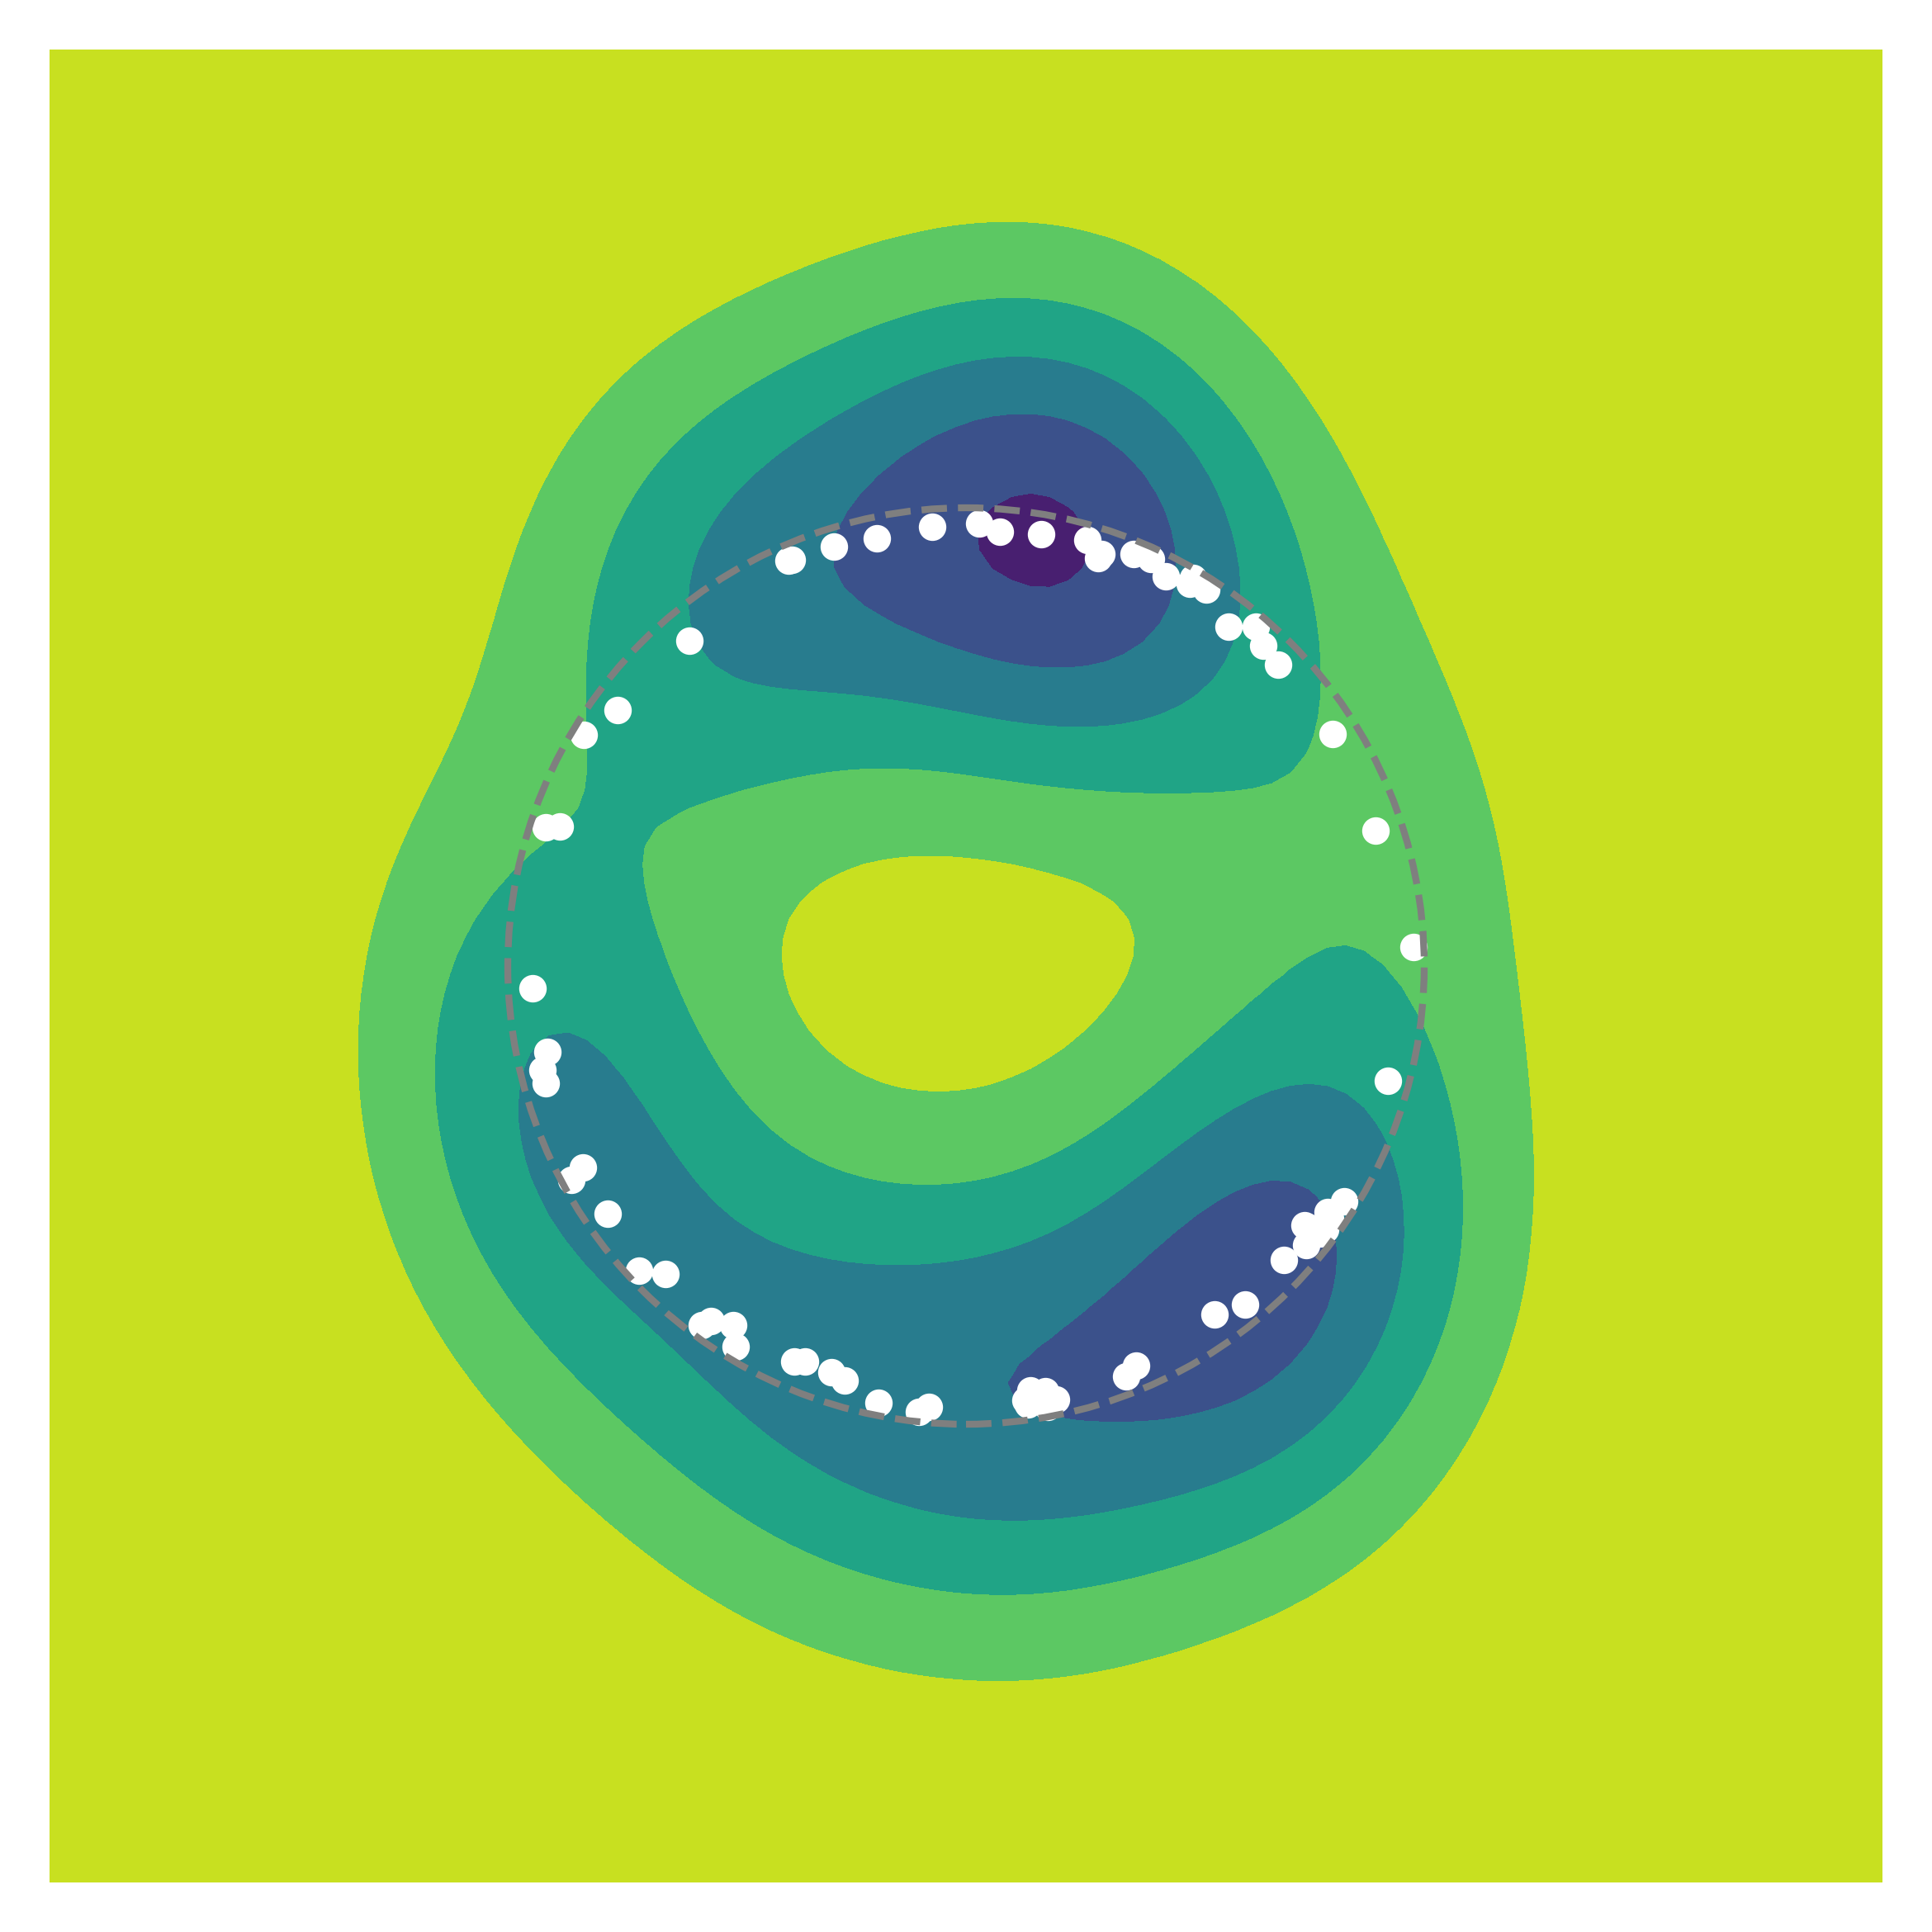

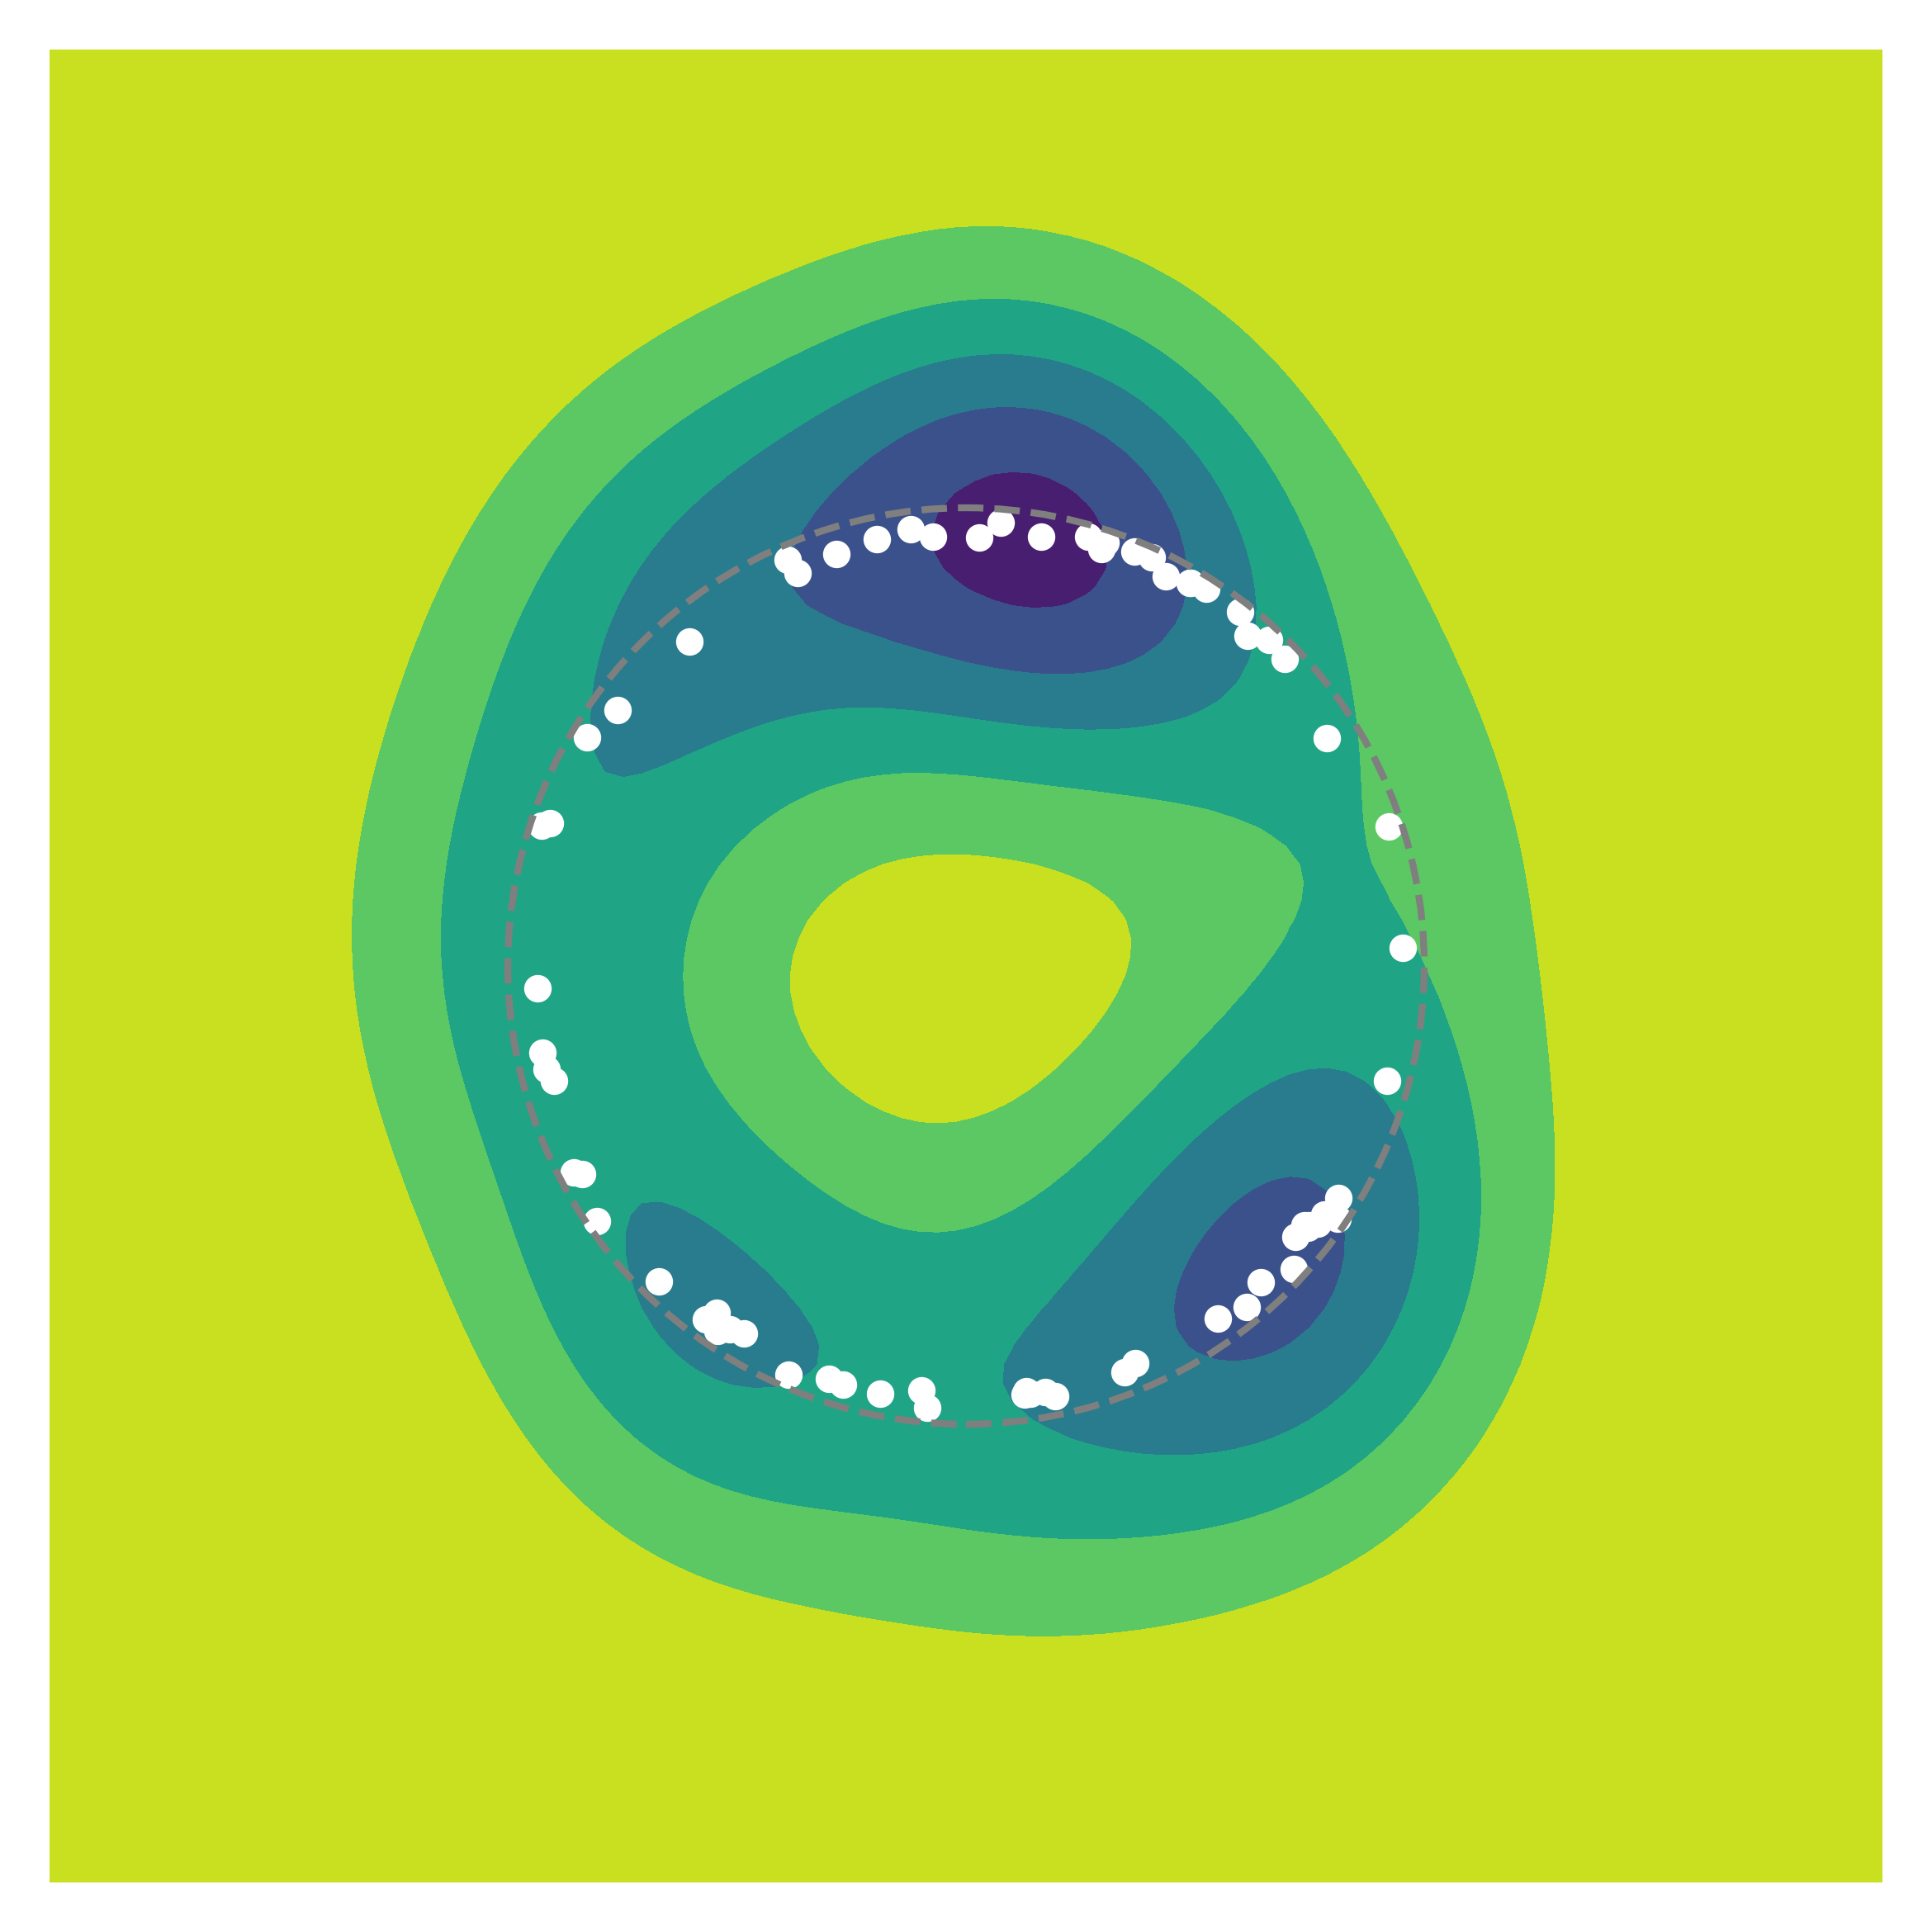

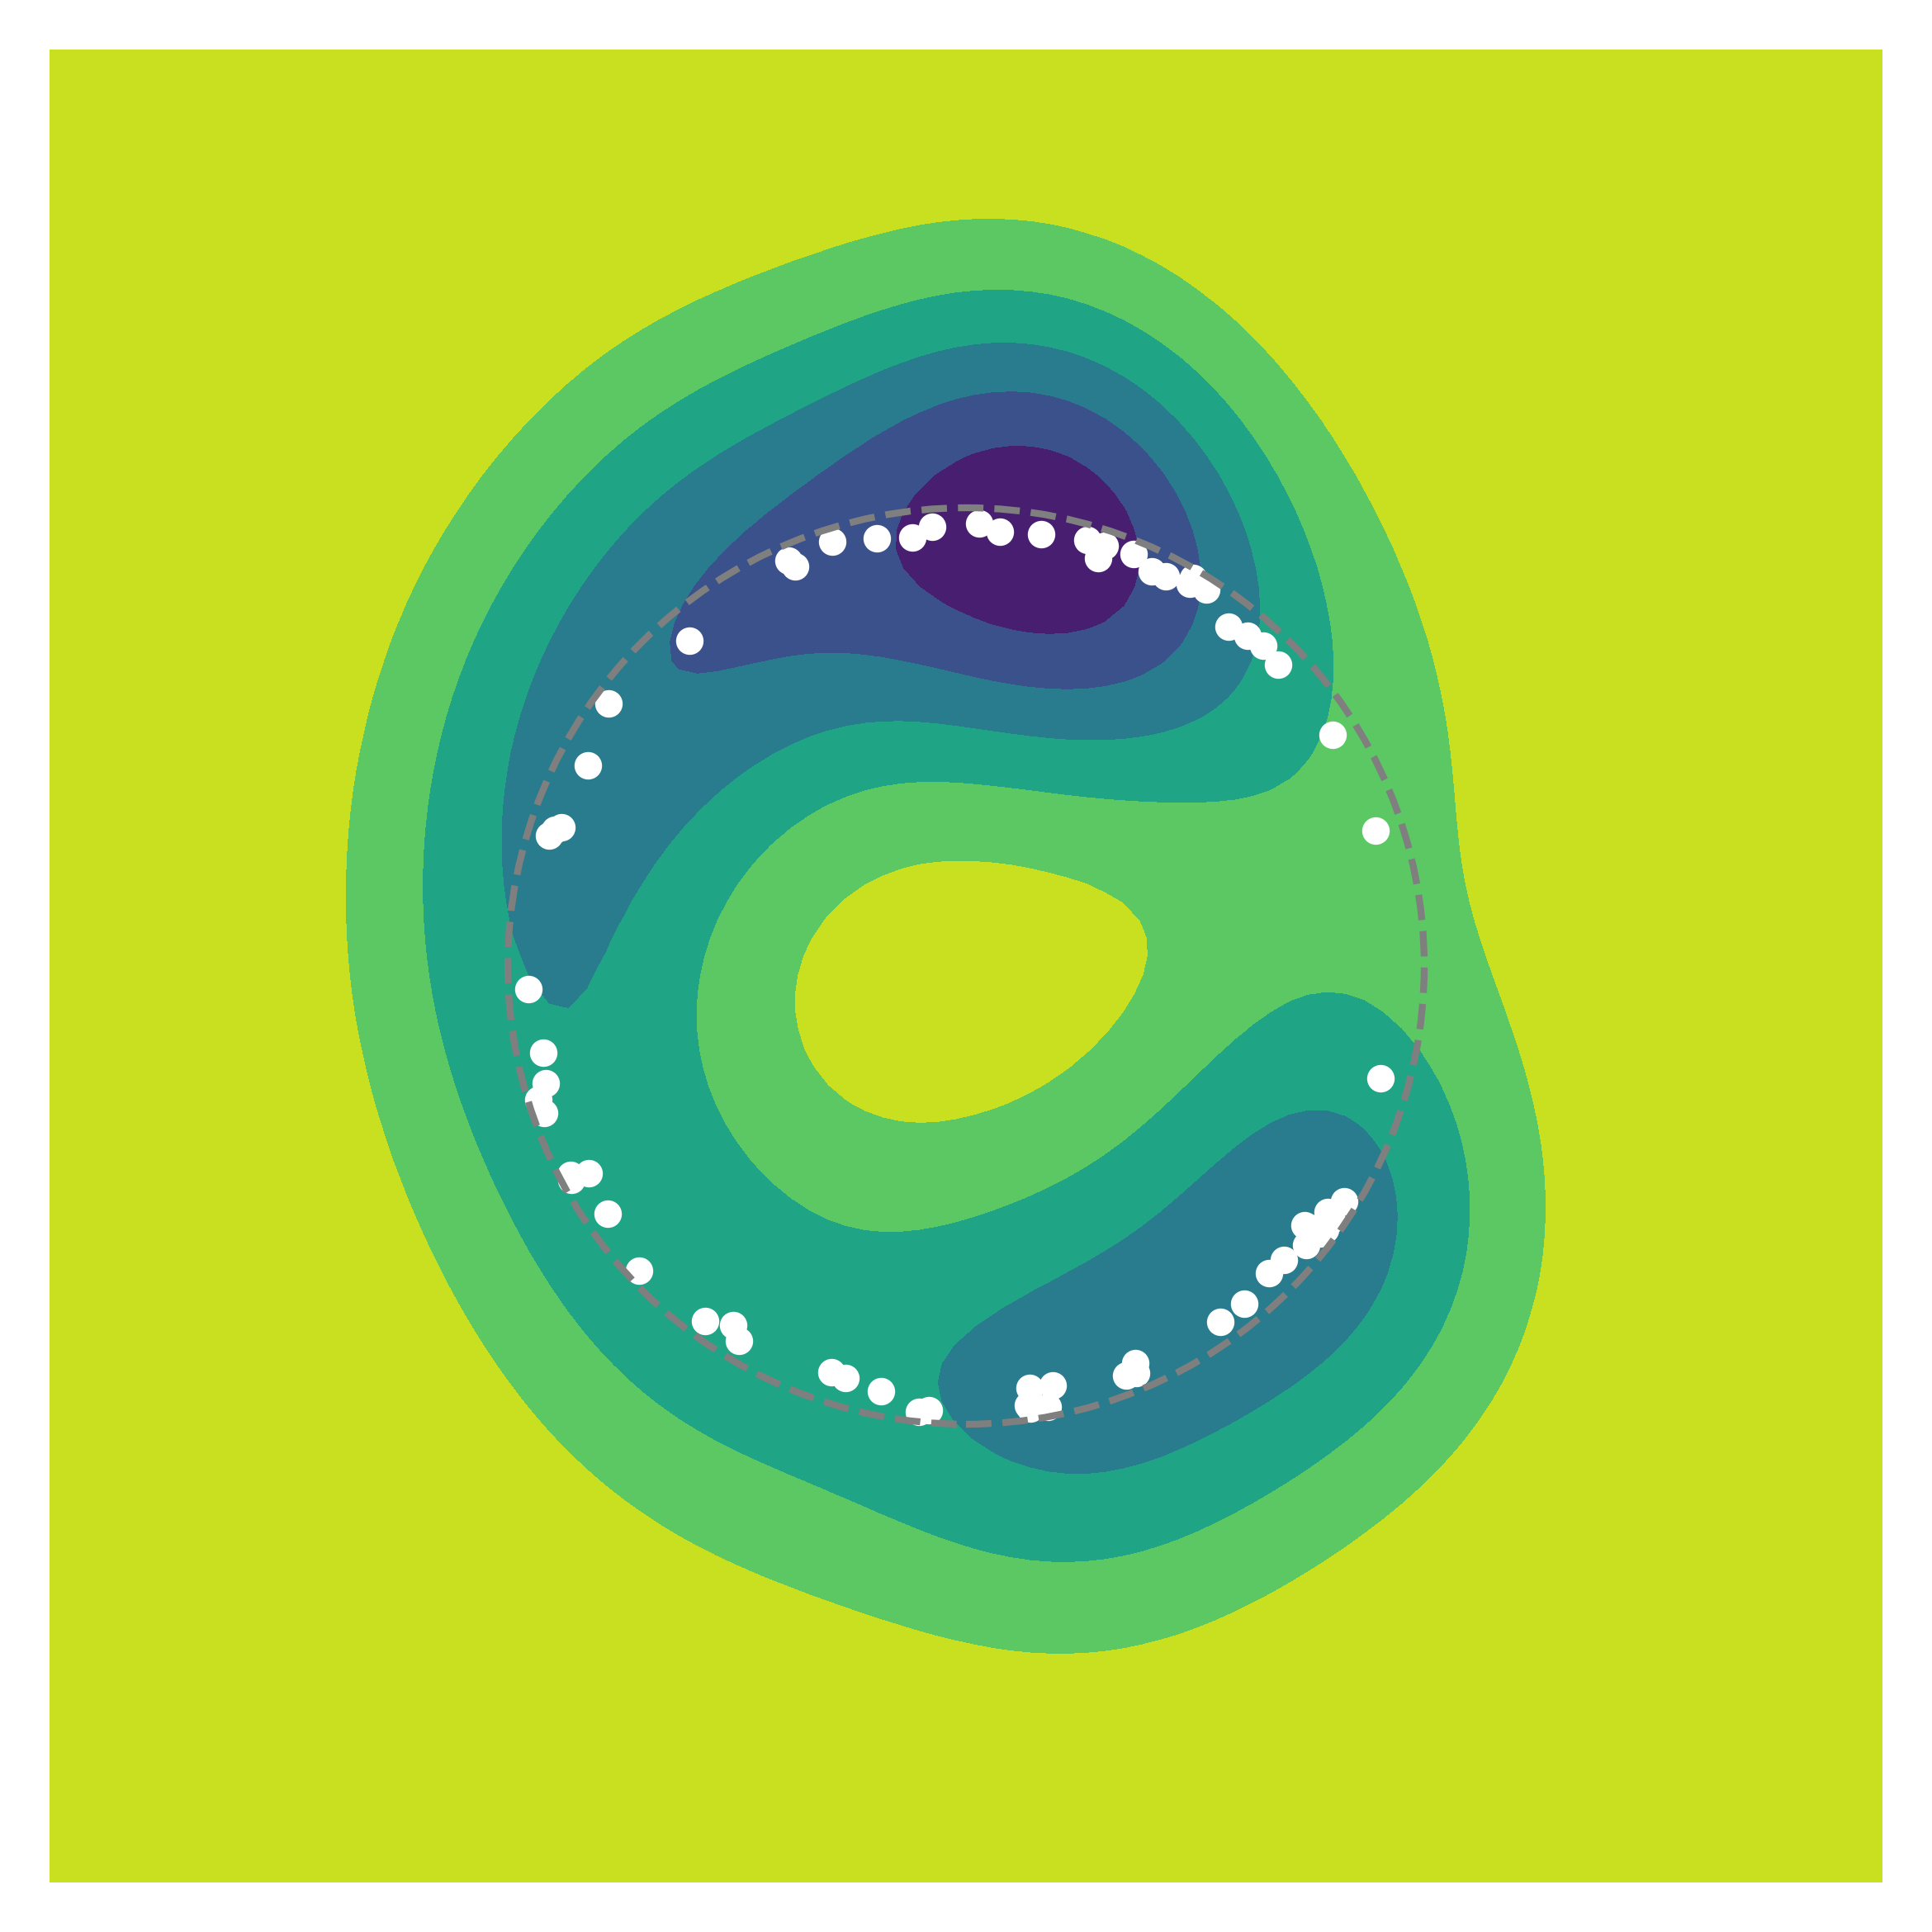

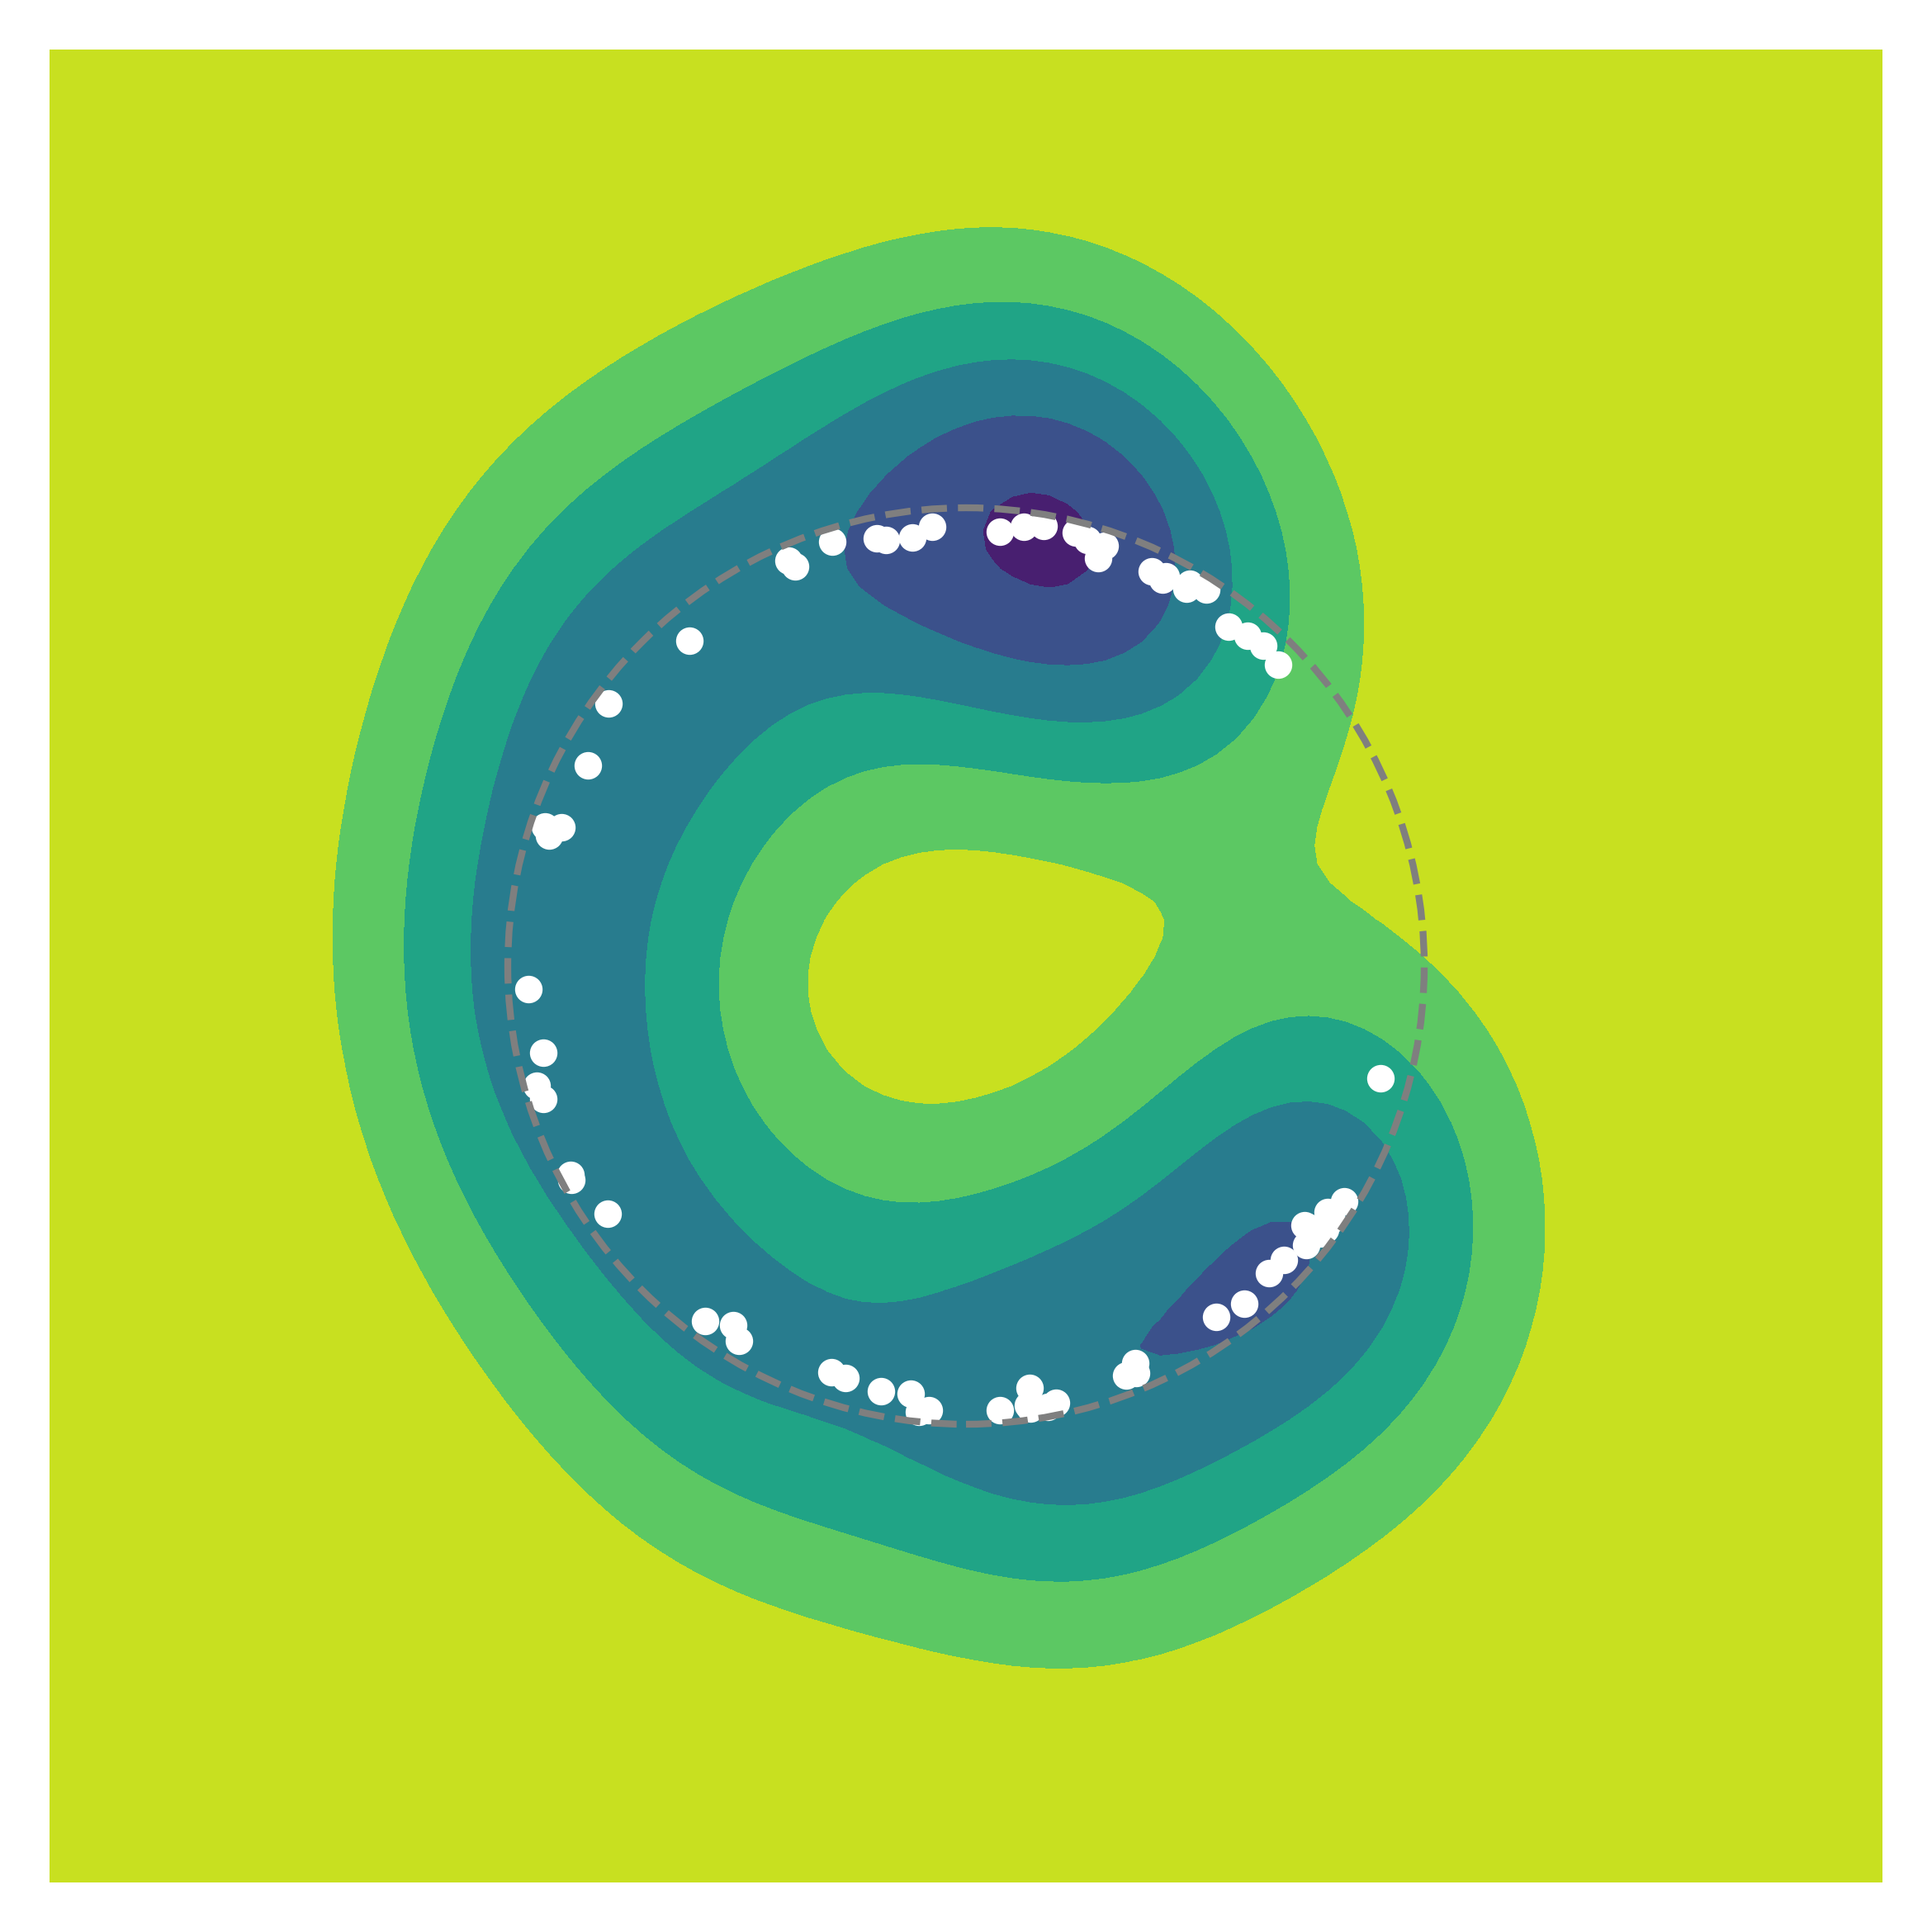

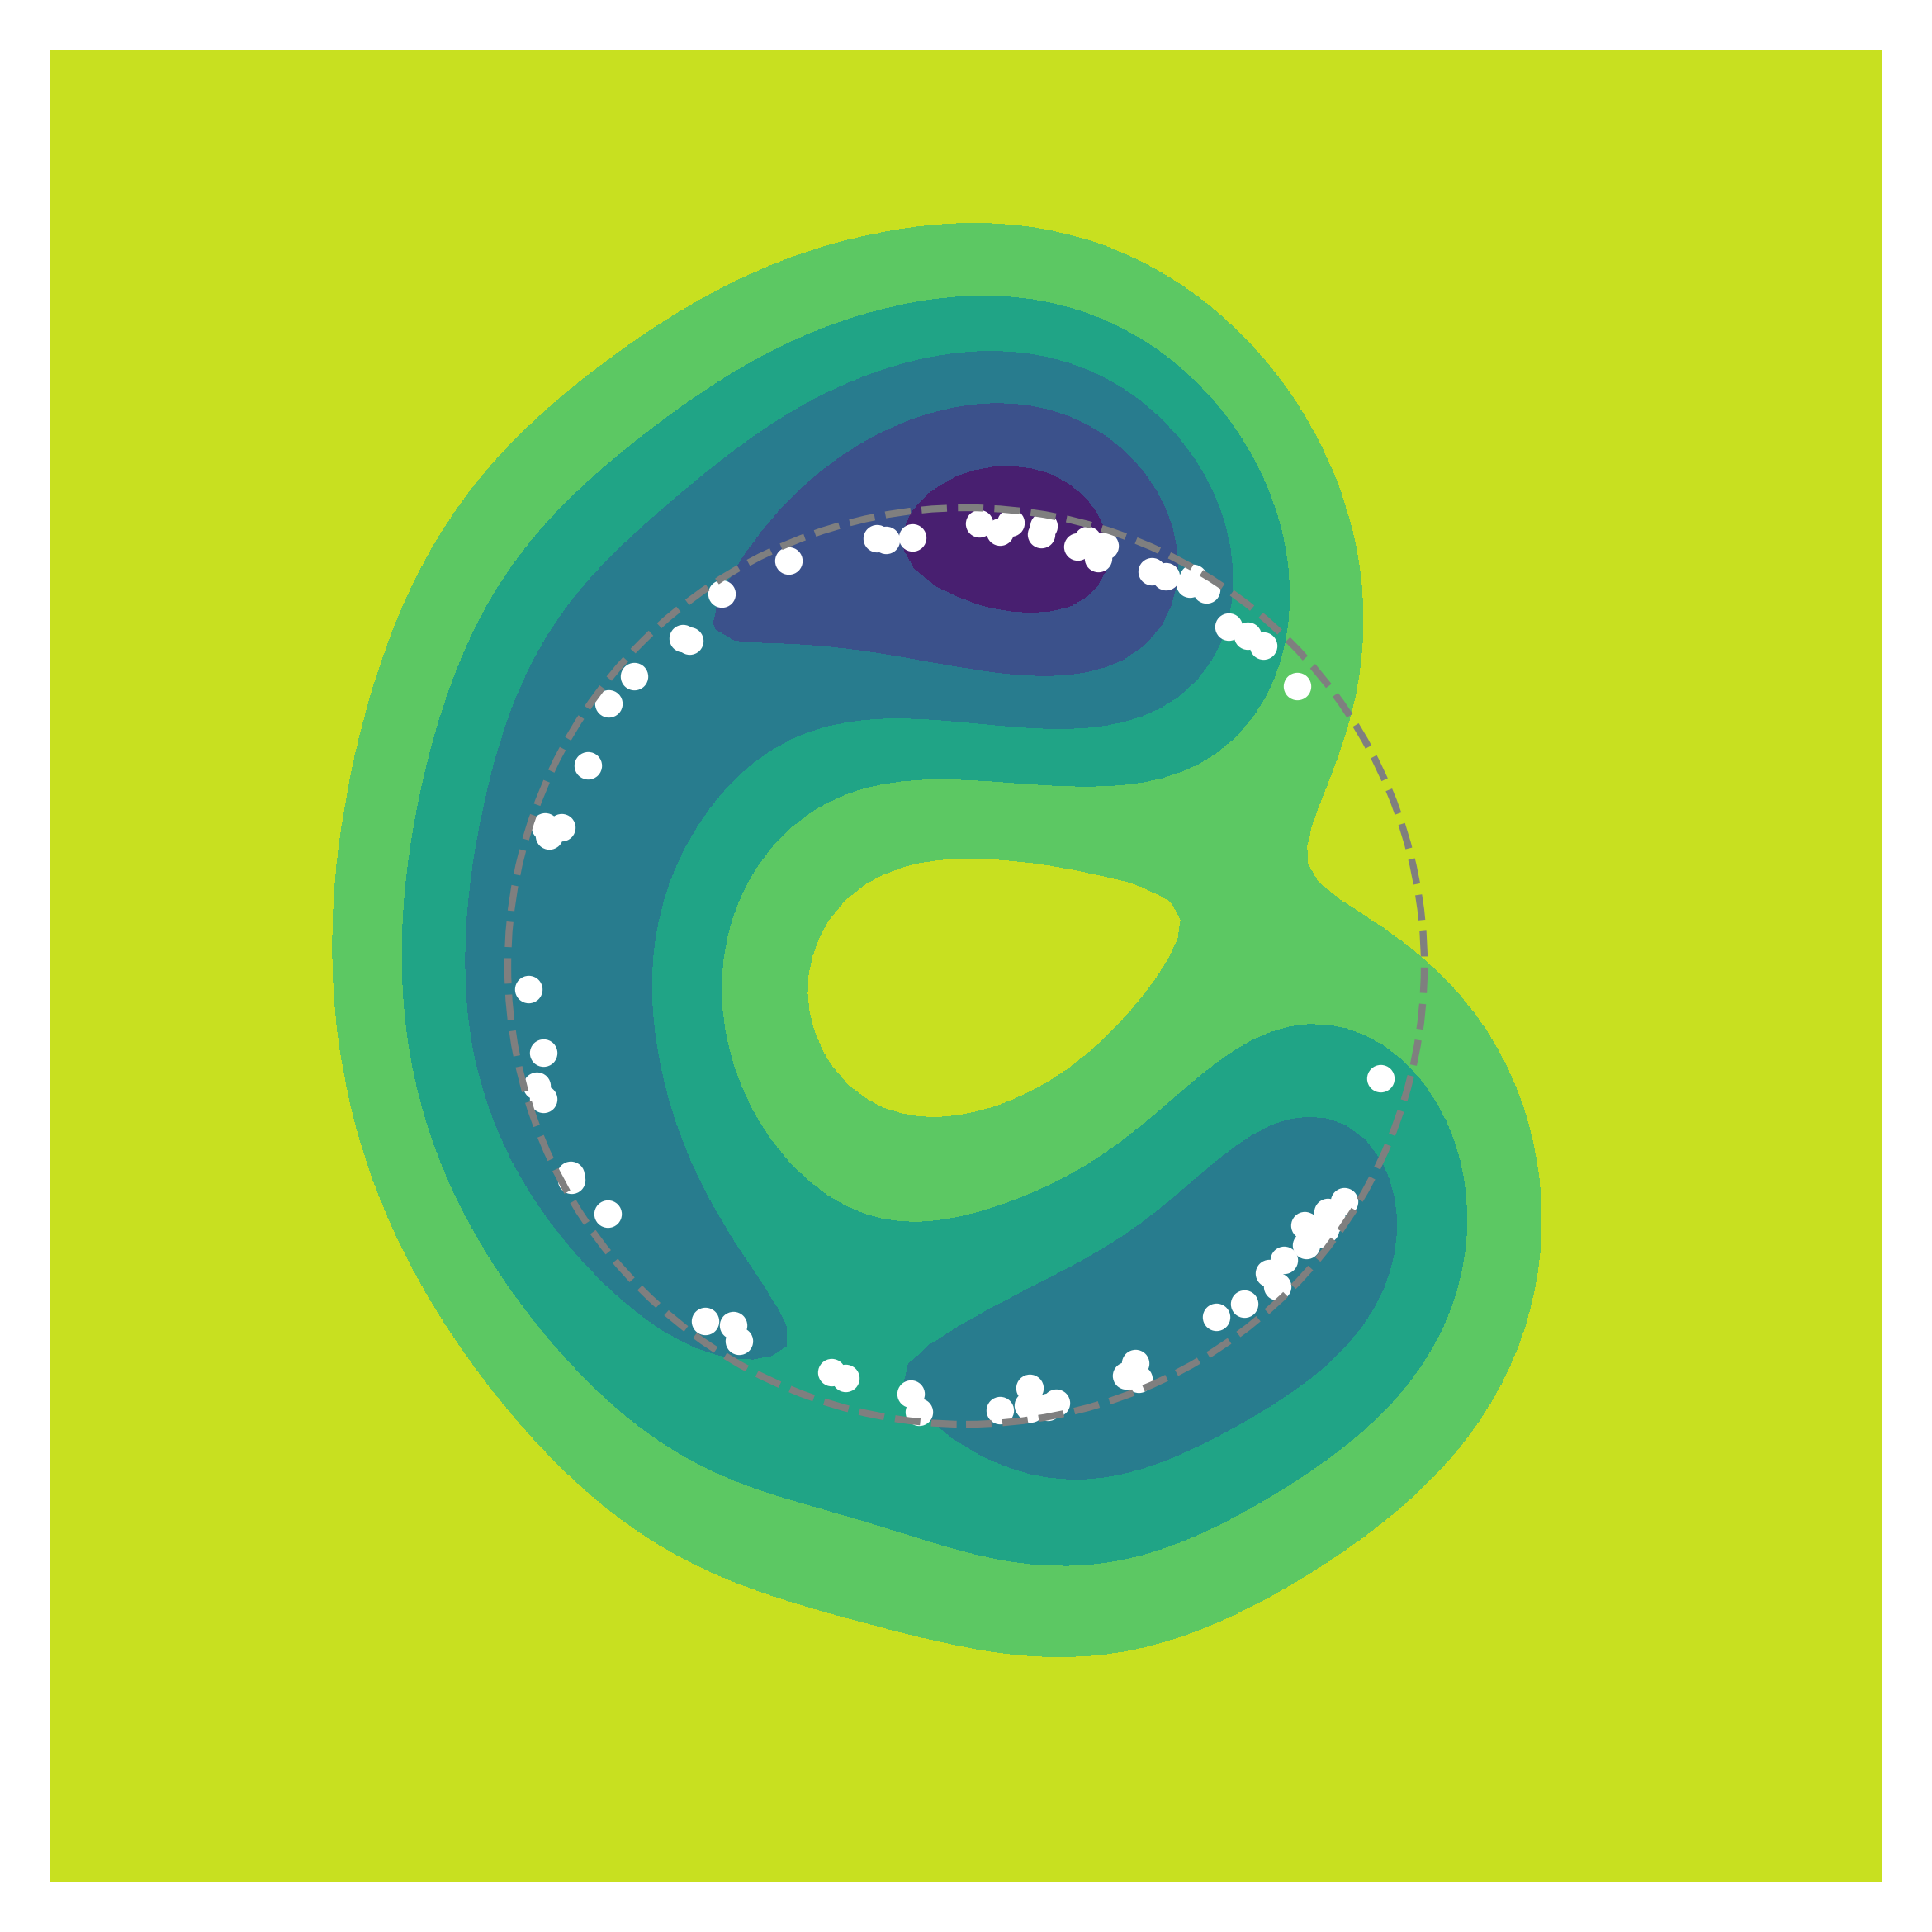

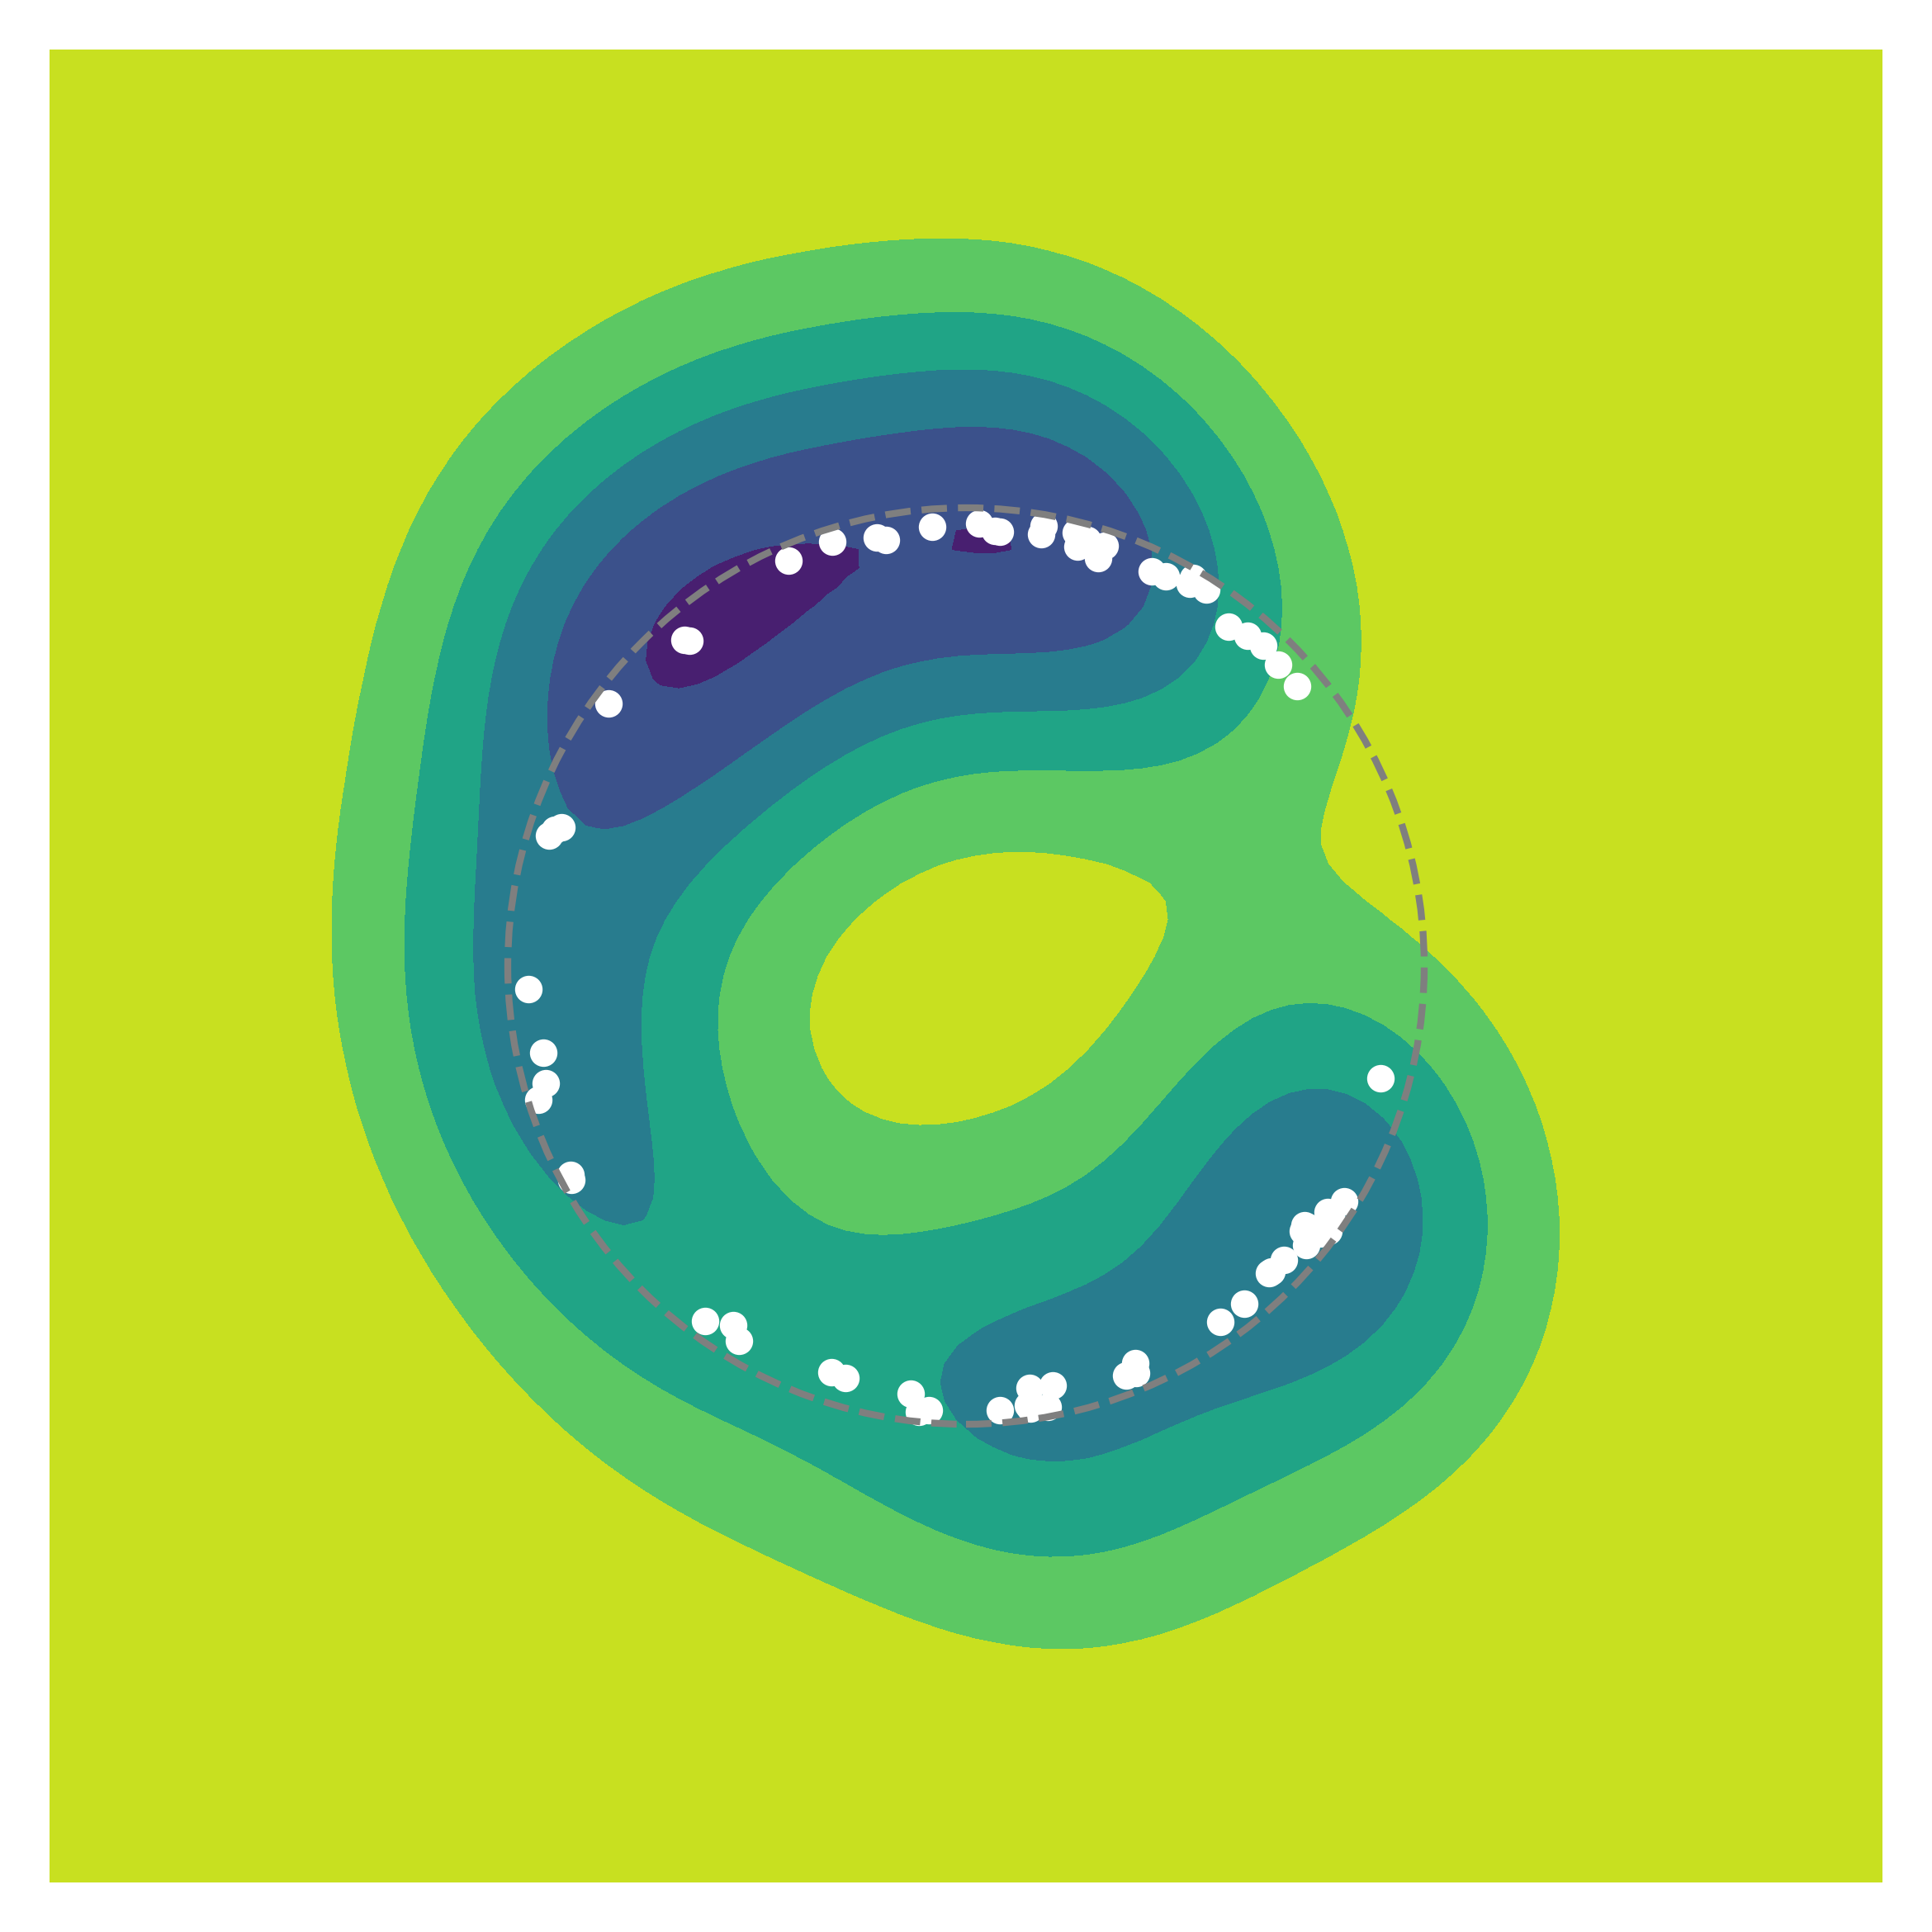

In [10]:
for epoch in epochs:
    contourplot(pop_histories, fit_history, lims=(-2, 2), epoch=epoch, filename=f"../img/circle_{epoch}")